In [2]:
from scipy.stats import norm
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, bioDraws, MonteCarlo, exp, log, Elem, PanelLikelihoodTrajectory, bioNormalCdf
from biogeme.expressions import Derive

from biogeme import models
from biogeme.models import ordered_probit, ordered_logit
from biogeme import results as res
from biogeme.results import compile_estimation_results, calcPValue
import pandas as pd
import biogeme.database as db
import numpy as np
import biogeme.distributions as dist
import pickle
from urllib.request import urlopen
import biogeme.results as res

import os

In [3]:
df=pd.read_csv('test_données.csv')

/var/folders/y0/0nrj3m412p978185q3d2503sr02q24/T/ipykernel_98333/3672760865.py:1: DtypeWarning: Columns (16,50,51,55,56,65,67,69,77,84,85,86,87,88,89,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('test_données.csv')


In [4]:
df['Gender_driver'] = df['Gender_driver'].astype(str)
df['Helmet_driver'] = df['Helmet_driver'].astype(str)

In [5]:
df=df[df['severity']!=-1]

In [6]:
df=df.loc[df['Vehicle'].isin(['E-scooter','Bike','E-bike','Pedestrian'])]

In [7]:
# Remplacer les NaN par une nouvelle catégorie
df['Road width'] = df['Road width'].fillna('Missing')
df['age_2'] = df['age_2'].fillna(0)
df['Maneuver_2'] = df['Maneuver_2'].fillna('Missing')


In [8]:
df['plan']=df['plan'].astype(str)

In [9]:
df_dummies=pd.get_dummies(df[['Crossroad','Helmet','Point of impact','Gender','vehicle_type_2','Vehicle','Pavement','tram','Intersection'
                              , 'User category', 'Lighting conditions', 'Cycle facilities', 'Road width', 'Agglomeration', 'Age category',
                              'Accident location', 'Surface condition', 'Maneuver', 'Maneuver_2','Gender_2', 'Pedestrian localisation', 'Pedestrian action', 'Vehicle_2',
'Max speed', 'Long profile', 'Weather conditions', 'Road type', 'Trip purpose','Reflective jacket', 'plan','Point of impact_2', 'Obstacle','Gender_driver','Helmet_driver','age_driver','Year', 'Maneuver_3','Point of impact_3','Gender_3','Vehicle_3'

]])
df_dummies = df_dummies.astype(int)  # Convert boolean to integers



In [10]:
# Select columns that are not of type object
df_non_object = df[['age','severity','Number of passengers','number of involved vehicles','vma','largeurcha','pentemoyen','largeurtro','age_2','catu', 'Num_Acc','age_opposite_mean']]


In [11]:
df_non_object=pd.concat([df_non_object,df_dummies],axis=1)
df_non_object['road segment']=df_non_object['Crossroad_No intersection']

In [12]:
df_non_object=df_non_object.dropna(subset=['age','severity'])

In [13]:
df_non_object = df_non_object.reset_index(drop=True)

In [14]:
df_non_object['largeurcha'].replace(np.nan,9999,inplace=True)
df_non_object['largeurtro'].replace(np.nan,9999,inplace=True)
df_non_object['pentemoyen'].replace(np.nan,9999,inplace=True)
df_non_object['age_opposite_mean'].replace(np.nan,9999,inplace=True)

/var/folders/y0/0nrj3m412p978185q3d2503sr02q24/T/ipykernel_98333/947835532.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_non_object['largeurcha'].replace(np.nan,9999,inplace=True)
/var/folders/y0/0nrj3m412p978185q3d2503sr02q24/T/ipykernel_98333/947835532.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [15]:
df_escooter=df_non_object.loc[df_non_object['Vehicle_E-scooter']==1]
df_ebike=df_non_object.loc[df_non_object['Vehicle_E-bike']==1]
df_bike=df_non_object.loc[df_non_object['Vehicle_Bike']==1]

In [16]:
df_non_object

,age,severity,Number of passengers,number of involved vehicles,vma,largeurcha,pentemoyen,largeurtro,age_2,catu,...,Vehicle_3_Bike,Vehicle_3_Bus,Vehicle_3_Car,Vehicle_3_E-bike,Vehicle_3_E-scooter,Vehicle_3_Mechanical PMD,Vehicle_3_Motorcycle,Vehicle_3_Pedestrian,Vehicle_3_Three-wheeled motorized,road segment
0,40.0,2,0,2,30,9999.0,9999.0,9999.0,62.0,1,...,0,0,0,0,0,0,0,0,0,1
1,19.0,2,0,2,30,9999.0,9999.0,9999.0,20.0,1,...,0,0,0,0,0,0,0,0,0,0
2,61.0,2,0,1,50,9999.0,9999.0,9999.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
3,32.0,2,0,2,30,9999.0,9999.0,9999.0,0.0,3,...,0,0,0,0,0,0,0,0,0,0
4,34.0,2,0,2,30,9999.0,9999.0,9999.0,48.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15581,21.0,2,1,2,50,9999.0,9999.0,9999.0,20.0,1,...,0,0,0,0,0,0,0,0,0,1
15582,22.0,1,1,2,50,9999.0,9999.0,9999.0,20.0,2,...,0,0,0,0,0,0,0,0,0,1
15583,35.0,2,0,2,30,2.7,2.0,4.0,44.0,1,...,0,0,0,0,0,0,0,0,0,1
15584,33.0,2,0,2,50,10.6,0.0,4.8,53.0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_carcrashes=df_non_object.loc[(df_non_object['vehicle_type_2_Cars']==1) | (df_non_object['vehicle_type_2_Large motorized vehicle'] ==1) | (df_non_object['vehicle_type_2_Light motorized vehicle']==1) ]
df_mmv=df_non_object.loc[(df_non_object['vehicle_type_2_Micromobility vehicle']==1) ]
df_alone=df_non_object.loc[df_non_object['vehicle_type_2_No other vehcile']==1]

df_carcrashes=df_carcrashes.loc[df_carcrashes['catu'].isin([1,2])]
df_mmv=df_mmv.loc[df_mmv['catu'].isin([1,2])]
df_mmv=df_mmv.loc[df_mmv['severity']!=3]
df_alone=df_alone.loc[df_alone['catu'].isin([1,2])]

num_acc_values = df_non_object.loc[df_non_object['vehicle_type_2_Pedestrian'] == 1, 'Num_Acc']

# Step 2: Filter the DataFrame to include rows with those Num_Acc values
df_pedestrian = df_non_object[df_non_object['Num_Acc'].isin(num_acc_values)]



df_carcrashes_escooter=df_escooter.loc[(df_escooter['vehicle_type_2_Cars']==1) | (df_escooter['vehicle_type_2_Large motorized vehicle'] ==1) | (df_escooter['vehicle_type_2_Light motorized vehicle']==1)]
df_carcrashes_ebike=df_ebike.loc[(df_ebike['vehicle_type_2_Cars']==1) | (df_ebike['vehicle_type_2_Large motorized vehicle'] ==1) | (df_ebike['vehicle_type_2_Light motorized vehicle']==1)]
df_carcrashes_bike=df_bike.loc[(df_bike['vehicle_type_2_Cars']==1) | (df_bike['vehicle_type_2_Large motorized vehicle'] ==1) | (df_bike['vehicle_type_2_Light motorized vehicle']==1)]


In [18]:
database_carcrashes = db.Database('database_carcrashes', df_carcrashes)
database_mmv= db.Database('database_mmv',df_mmv)
database_pedestrian= db.Database('database_pedestrian',df_pedestrian)
database_alone= db.Database('database_alone',df_alone)
database= db.Database('database',df_non_object)
database_carcrashes_escooter = db.Database('database_carcrashes_escooter', df_carcrashes_escooter)
database_carcrashes_ebike = db.Database('database_carcrashes_ebike', df_carcrashes_ebike)
database_carcrashes_bike = db.Database('database_carcrashes_bike', df_carcrashes_bike)


## Variables

In [19]:
age_020=Variable('Age category_0-20')
age_4160=Variable('Age category_41-60')
age_61=Variable('Age category_61+')
age=Variable('age')
age_opposite_mean=Variable('age_opposite_mean')
severity=Variable('severity')
Gender_Male=Variable('Gender_Male')
Gender_Female=Variable('Gender_Female')
Helmet=Variable('Helmet_Yes')
inv_car=Variable('Involved vehicle 1_Car')
Crossroad_no_traffic_lights=Variable('Crossroad_No traffic lights')
Crossroad_Traffic_lights=Variable('Crossroad_Traffic lights')
Crossroad_Roundabout=Variable('Crossroad_Roundabouts')
passengers=Variable('Number of passengers')
nb_involved_vehi=Variable('number of involved vehicles')
vma=Variable('vma')
e_scooter=Variable('Vehicle_E-scooter')
bike=Variable('Vehicle_Bike')
ebike=Variable('Vehicle_E-bike')
vehicle_car=Variable('Vehicle_Car')
e_scooter_2=Variable('Vehicle_2_E-scooter')
bike_2=Variable('Vehicle_2_Bike')
ebike_2=Variable('Vehicle_2_E-bike')
e_scooter_3=Variable('Vehicle_3_E-scooter')
bike_3=Variable('Vehicle_3_Bike')
ebike_3=Variable('Vehicle_3_E-bike')

e_car_2=Variable('Vehicle_2_Car')
heavy_motorized=Variable('vehicle_type_2_Large motorized vehicle')
light_motorized=Variable('vehicle_type_2_Light motorized vehicle')
light_non_motorized=Variable('Involved vehicle 1 type_Light non-motorized vehicle')
no_other_vehicle=Variable('Involved vehicle 1 type_No other vehicle')
inv_pedestrian=Variable('Involved vehicle 1 type_Pedestrian')
back=Variable('Point of impact_Back')
left=Variable('Point of impact_Left side')
right=Variable('Point of impact_Right side')

back_opposite=Variable('Point of impact_opposite_Back')
left_opposite=Variable('Point of impact_opposite_Left side')
right_opposite=Variable('Point of impact_opposite_Right side')


no_int=Variable('Intersection_No intersection')
paved=Variable('Pavement_Paved')
roadwidth1012m=Variable('Road width_10-12 m')
roadwidth46m=Variable('Road width_4-6 m')	
roadwidth68m=Variable('Road width_6-8 m')	
roadwidth810m=Variable('Road width_8-10 m')	
roadwidth4m=Variable('Road width_<4 m')
roadwidth12m=Variable('Road width_> 12m')
roadwidth_missing=Variable('Road width_Missing')
driver=Variable('User category_Driver')
passenger=Variable('User category_Passenger')
pedestrian=Variable('User category_Pedestrian')
lyon= Variable('Agglomeration_MÉTROPOLE DE LYON')
paris= Variable('Agglomeration_MÉTROPOLE DU GRAND PARIS')

night_light=Variable('Lighting conditions_Night with street lightings on')
night=Variable('Lighting conditions_Night without street lightings')
twilight=Variable('Lighting conditions_Twilight')
daylight=Variable('Lighting conditions_Daylight')

roadwidth=Variable('largeurcha')

morning_peak=Variable('Time of day_Morning peak hours')
afternoon_peak=Variable('Time of day_Afternoon peak hours')

road_segment=Variable('road segment')
pentemoyen=Variable('pentemoyen')
largeurtro=Variable('largeurtro')
female_opposite=Variable('Gender_2_Female')
female_opposite_3=Variable('Gender_3_Female')

on_cycle=Variable('Accident location_On cycle facility')
on_special_way=Variable('Accident location_On other special way')
on_sidewalk=Variable('Accident location_On sidewalk')
on_road=Variable('Accident location_On road')

Intersection_Cross=Variable('Intersection_Cross intersection')
Intersection_T=Variable('Intersection_T intersection')
Intersection_Square=Variable('Intersection_Square')
Intersection_Y=Variable('Intersection_Y intersection')

# Déclaration des variables
cycle_facilities_bus_lane = Variable('Cycle facilities_Bus lane')
cycle_facilities_cycle_lane = Variable('Cycle facilities_Cycle lane')
cycle_facilities_cycle_path_greenway = Variable('Cycle facilities_Cycle path/Greenway')
cycle_facilities_no_cycle_facilities = Variable('Cycle facilities_No cycle facilities')
cycle_facilities_pedestrianized_street = Variable('Cycle facilities_Pedestrianized street')
cycle_facilities_two_way_cycle = Variable('Cycle facilities_Two-way cycle')

# Déclaration des variables
tram_on_tracks = Variable('tram_On tracks')
tram_tram_crossing = Variable('tram_Tram crossing')

wet=Variable('Surface condition_Wet')

# Déclaration des variables
maneuver_crossing_road = Variable('Maneuver_Crossing the road')
maneuver_deported = Variable('Maneuver_Deported')
maneuver_opposite_direction = Variable('Maneuver_In the opposite direction')
maneuver_other = Variable('Maneuver_Other')
maneuver_overtaking = Variable('Maneuver_Overtaking')
maneuver_turning_left = Variable('Maneuver_Turning left')
maneuver_turning_right = Variable('Maneuver_Turning right')

maneuver_without_change_direction = Variable('Maneuver_Without change of direction')

age_involved=Variable('age_2')
maneuver_crossing_road_involved = Variable('Maneuver_2_Crossing the road')
maneuver_deported_involved = Variable('Maneuver_2_Deported')
maneuver_opposite_direction_involved = Variable('Maneuver_2_In the opposite direction')
maneuver_other_involved = Variable('Maneuver_2_Other')
maneuver_overtaking_involved = Variable('Maneuver_2_Overtaking')
maneuver_turning_involved_right = Variable('Maneuver_2_Turning left')
maneuver_turning_involved_left = Variable('Maneuver_2_Turning right')
maneuver_involved_parked = Variable('Maneuver_2_Parked')

age_involved_3=Variable('age_3')
maneuver_crossing_road_involved_3 = Variable('Maneuver_3_Crossing the road')
maneuver_deported_involved_3= Variable('Maneuver_3_Deported')
maneuver_opposite_direction_involved_3 = Variable('Maneuver_3_In the opposite direction')
maneuver_other_involved_3 = Variable('Maneuver_3_Other')
maneuver_overtaking_involved_3 = Variable('Maneuver_3_Overtaking')
maneuver_turning_involved_right_3 = Variable('Maneuver_3_Turning left')
maneuver_turning_involved_left_3 = Variable('Maneuver_3_Turning right')
maneuver_involved_parked_3 = Variable('Maneuver_3_Parked')

poteau=Variable('Obstacle_Poteau')
bordure=Variable('Obstacle_Sidewalk bordure')
parked_vehi=Variable('Obstacle_Parked_vehicle')


maneuver_without_change_direction_involved = Variable('Maneuver_2_Without change of direction')
maneuver_door_opening_involved = Variable('Maneuver_2_Door opening')

vehicle_type_2_Cars=Variable('vehicle_type_2_Cars')
vehicle_type_2_Large_motorized_vehicle= Variable('vehicle_type_2_Large motorized vehicle')
vehicle_type_2_Light_motorized_vehicle=Variable('vehicle_type_2_Light motorized vehicle')
vehicle_type_2_Micromobility_vehicle=Variable('vehicle_type_2_Micromobility vehicle')
vehicle_type_2_Pedestrian=Variable('vehicle_type_2_Pedestrian')
no_other_vehicle=Variable('vehicle_type_2_No other vehicle')

pedestrian_crossing=Variable('Pedestrian action_Crossing')
pedestrian_moving=Variable('Pedestrian action_Moving')

MaxSpeed_20=Variable('Max speed_20 km/h')
MaxSpeed_30=Variable('Max speed_30 km/h')
MaxSpeed_50=Variable('Max speed_50 km/h')
MaxSpeed_10=Variable('Max speed_< 10 km/h')

pedestrian_on_crossing=Variable('Pedestrian localisation_On a pedestrian crossing')
pedestrian_on_road=Variable('Pedestrian localisation_On the road')
pedestrian_on_sidewalk=Variable('Pedestrian localisation_On sidewalk')

slope=Variable('Long profile_Slope')

normal_weather=Variable('Weather conditions_Normal')
cloudy_weather=Variable('Weather conditions_Cloudy / Fog')
rainy_weather=Variable('Weather conditions_Rain / Snow')

cycleway=Variable('Road type_Cycleway')
path=Variable('Road type_Path')
pedestrian_area=Variable('Road type_Pedestrian area')
primary=Variable('Road type_Primary')
residential=Variable('Road type_Residential')
secondary=Variable('Road type_Secondary')
tertiary=Variable('Road type_Tertiary')

leisure=Variable('Trip purpose_Leisure/Shopping')
jacket_yes=Variable('Reflective jacket_Yes')
prof_use=Variable('Trip purpose_Professional use')

plan_2=Variable('plan_2')
plan_3=Variable('plan_3')

Helmet_driver_Yes=Variable('Helmet_driver_Yes')
Gender_driver_Female=Variable('Gender_driver_Female')
Age_driver=Variable('age_driver')


In [20]:
l=pd.DataFrame(df_non_object.columns)

## Betas 1

In [21]:
constant_2 = Beta('constant_2', 0, None, None, 0)
constant_3 = Beta('constant_3', 0, None, None, 0)
constant_4 = Beta('constant_4', 0, None, None, 0)

Beta_female = Beta('Beta Female', 0, None, None, 0)
Beta_female_2=Beta('Beta Female 2', 0, None, None, 0)
Beta_female_3=Beta('Beta Female 3', 0, None, None, 0)
Beta_female_4=Beta('Beta Female 4', 0, None, None, 0)

Beta_age_020_2 = Beta('Beta_age_020_2', 0, None, None, 0)
Beta_age_020_3 = Beta('Beta_age_020_3', 0, None, None, 0)
Beta_age_020_4 = Beta('Beta_age_020_4', 0, None, None, 0)
Beta_age_61_2 = Beta('Beta_age_61_2', 0, None, None, 0)
Beta_age_61_3 = Beta('Beta_age_61_3', 0, None, None, 0)
Beta_age_61_4 = Beta('Beta_age_61_4', 0, None, None, 0)
Beta_age_4160_2 = Beta('Beta_age_4160_2', 0, None, None, 0)
Beta_age_4160_3 = Beta('Beta_age_4160_3', 0, None, None, 0)
Beta_age_4160_4 = Beta('Beta_age_4160_4', 0, None, None, 0)
Beta_age_020 = Beta('Beta_age_020', 0, None, None, 0)
Beta_age_61 = Beta('Beta_age_61', 0, None, None, 0)
Beta_age_4160 = Beta('Beta_age_4160', 0, None, None, 0)

Beta_age_2= Beta('Beta_age_2', 0, None, None, 0)
Beta_age_3= Beta('Beta_age_3', 0, None, None, 0)
Beta_age_4= Beta('Beta_age_4', 0, None, None, 0)
Beta_age= Beta('Beta_age', 0, None, None, 0)


Beta_helmet=Beta('Beta_helmet', 0, None, None, 0)
Beta_helmet_2=Beta('Beta_helmet 2', 0, None, None, 0)
Beta_helmet_3=Beta('Beta_helmet 3', 0, None, None, 0)
Beta_helmet_4=Beta('Beta_helmet 4', 0, None, None, 0)

Beta_helmet_ebike=Beta('Beta_helmet_ebike', 0, None, None, 0)
Beta_helmet_escooter=Beta('Beta_helmet_escooter', 0, None, None, 0)

Beta_vma=Beta('Beta_vma',0,None,None,0)
Beta_vma_2=Beta('Beta_vma_2',0,None,None,0)
Beta_vma_3=Beta('Beta_vma_3',0,None,None,0)
Beta_vma_4=Beta('Beta_vma_4',0,None,None,0)


Beta_ebike_2=Beta('Beta_ebike 2',0,None,None,0)
Beta_escooter_2=Beta('Beta_escooter 2',0,None,None,0)
Beta_ebike_3=Beta('Beta_ebike 3',0,None,None,0)
Beta_escooter_3=Beta('Beta_escooter 3',0,None,None,0)
Beta_ebike_4=Beta('Beta_ebike 4',0,None,None,0)
Beta_escooter_4=Beta('Beta_escooter 4',0,None,None,0)

Beta_ebike_2_opposite=Beta('Beta_ebike 2_opposite',0,None,None,0)
Beta_escooter_2_opposite=Beta('Beta_escooter 2_opposite',0,None,None,0)
Beta_ebike_3_opposite=Beta('Beta_ebike 3_opposite',0,None,None,0)
Beta_escooter_3_opposite=Beta('Beta_escooter 3_opposite',0,None,None,0)
Beta_ebike_4_opposite=Beta('Beta_ebike 4_opposite',0,None,None,0)
Beta_escooter_4_opposite=Beta('Beta_escooter 4_opposite',0,None,None,0)

Beta_crossroad_traffic_lights=Beta('Beta_crossroad_traffic_lights', 0, None, None, 0)
Beta_crossroad_roundabout=Beta('Beta_crossroad_roundabout', 0, None, None, 0)

Beta_crossroad_traffic_lights_2=Beta('Beta_crossroad_traffic_lights 2', 0, None, None, 0)
Beta_crossroad_roundabout_2=Beta('Beta_crossroad_roundabout 2', 0, None, None, 0)
Beta_crossroad_traffic_lights_3=Beta('Beta_crossroad_traffic_lights 3', 0, None, None, 0)
Beta_crossroad_roundabout_3=Beta('Beta_crossroad_roundabout 3', 0, None, None, 0)
Beta_crossroad_traffic_lights_4=Beta('Beta_crossroad_traffic_lights 4', 0, None, None, 0)
Beta_crossroad_roundabout_4=Beta('Beta_crossroad_roundabout 4', 0, None, None, 0)
Beta_crossroad_no_traffic_lights_2=Beta('Beta_crossroad_no_traffic_lights 2', 0, None, None, 0)
Beta_crossroad_no_traffic_lights_3=Beta('Beta_crossroad_no_traffic_lights 3', 0, None, None, 0)
Beta_crossroad_no_traffic_lights_4=Beta('Beta_crossroad_no_traffic_lights 4', 0, None, None, 0)

Beta_passengers=Beta('Beta_passengers', 0, None, None, 0)
Beta_passengers_2=Beta('Beta_passengers 2', 0, None, None, 0)
Beta_passengers_3=Beta('Beta_passengers 3', 0, None, None, 0)
Beta_passengers_4=Beta('Beta_passengers 4', 0, None, None, 0)

Beta_nb_involved_vehi=Beta('Beta_nb_involved_vehi', 0, None, None, 0)
Beta_nb_involved_vehi_2=Beta('Beta_nb_involved_vehi 2', 0, None, None, 0)
Beta_nb_involved_vehi_3=Beta('Beta_nb_involved_vehi 3', 0, None, None, 0)
Beta_nb_involved_vehi_4=Beta('Beta_nb_involved_vehi 4', 0, None, None, 0)

Beta_involved_vehicle_car=Beta('Beta_involved_vehicle_car', 0, None, None, 0)

Beta_light_motorized=Beta('Beta Involved vehicle 1 type_Light motorized vehicle', 0, None, None, 0)
Beta_light_non_motorized=Beta('Beta Involved vehicle 1 type_Light non-motorized vehicle', 0, None, None, 0)
Beta_no_other_vehicle=Beta('Beta Involved vehicle 1 type_No other vehicle', 0, None, None, 0)
Beta_inv_pedestrian=Beta('Beta Involved vehicle 1 type_Pedestrian', 0, None, None, 0)

Beta_back=Beta('Beta Point of impact_Back', 0, None, None, 0)

Beta_back_2=Beta('Beta Point of impact_Back 2', 0, None, None, 0)
Beta_back_3=Beta('Beta Point of impact_Back 3', 0, None, None, 0)
Beta_back_4=Beta('Beta Point of impact_Back 4', 0, None, None, 0)

Beta_left=Beta('Beta Point of impact_Left', 0, None, None, 0)
Beta_right=Beta('Beta Point of impact_Right', 0, None, None, 0)

Beta_left_2=Beta('Beta Point of impact_Left 2', 0, None, None, 0)
Beta_right_2=Beta('Beta Point of impact_Right 2', 0, None, None, 0)
Beta_left_3=Beta('Beta Point of impact_Left 3', 0, None, None, 0)
Beta_right_3=Beta('Beta Point of impact_Right 3', 0, None, None, 0)
Beta_left_4=Beta('Beta Point of impact_Left 4', 0, None, None, 0)
Beta_right_4=Beta('Beta Point of impact_Right 4', 0, None, None, 0)

Beta_opposite_back_2=Beta('Beta Point of impact_opposite_Back 2', 0, None, None, 0)
Beta_opposite_back_3=Beta('Beta Point of impact_opposite_Back 3', 0, None, None, 0)
Beta_opposite_back_4=Beta('Beta Point of impact_opposite_Back 4', 0, None, None, 0)



Beta_left_opposite_2=Beta('Beta Point of impact_opposite_Left 2', 0, None, None, 0)
Beta_right_opposite_2=Beta('Beta Point of impact_opposite_Right 2', 0, None, None, 0)
Beta_left_opposite_3=Beta('Beta Point of impact_opposite_Left 3', 0, None, None, 0)
Beta_right_opposite_3=Beta('Beta Point of impact_opposite_Right 3', 0, None, None, 0)
Beta_lef_oppositet_4=Beta('Beta Point of impact_opposite_Left 4', 0, None, None, 0)
Beta_right_opposite_4=Beta('Beta Point of impact_opposite_Right 4', 0, None, None, 0)


Beta_paved_2=Beta('Beta Paved 2',0, None, None, 0)
Beta_paved_3=Beta('Beta Paved 3',0, None, None, 0)
Beta_paved_4=Beta('Beta Paved 4',0, None, None, 0)
Beta_paved=Beta('Beta Paved',0, None, None, 0)

Beta_roadwidth1012m=Beta('Beta Road width_20-12 m',0, None, None, 0)
Beta_roadwidth46m=Beta('Beta Road width_4-6 m',0, None, None, 0)	
Beta_roadwidth68m=Beta('Beta Road width_6-8 m',0, None, None, 0)	
Beta_roadwidth810m=Beta('Beta Road width_8-10 m',0, None, None, 0)	
Beta_roadwidth4m=Beta('Beta Road width_<4 m',0, None, None, 0)
Beta_roadwidth12m=Beta('Beta Road width_> 12m',0, None, None, 0)
Beta_roadwidth_missing=Beta('Beta Road width_Missing',0, None, None, 0)
Beta_roadwidth_2=Beta('Beta Road width 2',0, None, None, 0)
Beta_roadwidth_3=Beta('Beta Road width 3',0, None, None, 0)
Beta_roadwidth_4=Beta('Beta Road width 4',0, None, None, 0)
Beta_roadwidth=Beta('Beta Road width',0, None, None, 0)


Beta_pedestrian=Beta('Beta User category_Pedestrian 2',0, None, None, 0)
Beta_pedestrian_2=Beta('Beta User category_Pedestrian 2',0, None, None, 0)
Beta_pedestrian_3=Beta('Beta User category_Pedestrian 3',0, None, None, 0)
Beta_pedestrian_4=Beta('Beta User category_Pedestrian 4',0, None, None, 0)

Beta_lyon= Beta('Beta Lyon', 0, None, None, 0 )

Beta_daylight_2=Beta('Beta Lighting conditions_Daylight 2',0, None, None, 0)
Beta_daylight_3=Beta('Beta Lighting conditions_Daylight 3',0, None, None, 0)
Beta_daylight_4=Beta('Beta Lighting conditions_Daylight 4',0, None, None, 0)

Beta_night_light_2=Beta('Beta Lighting conditions_Night with street lightings on 2',0, None, None, 0)
Beta_night_2=Beta('Beta Lighting conditions_Night without street lightings 2',0, None, None, 0)
Beta_twilight_2=Beta('Beta Lighting conditions_Twilight 2',0, None, None, 0)

Beta_night_light_3=Beta('Beta Lighting conditions_Night with street lightings on 3',0, None, None, 0)
Beta_night_3=Beta('Beta Lighting conditions_Night without street lightings 3',0, None, None, 0)
Beta_twilight_3=Beta('Beta Lighting conditions_Twilight 3',0, None, None, 0)

Beta_night_light_4=Beta('Beta Lighting conditions_Night with street lightings on 4',0, None, None, 0)
Beta_night_4=Beta('Beta Lighting conditions_Night without street lightings 4',0, None, None, 0)
Beta_twilight_4=Beta('Beta Lighting conditions_Twilight 4',0, None, None, 0)


Beta_night_light=Beta('Beta Lighting conditions_Night with street lightings on ',0, None, None, 0)
Beta_night=Beta('Beta Lighting conditions_Night without street lightings ',0, None, None, 0)
Beta_twilight=Beta('Beta Lighting conditions_Twilight',0, None, None, 0)

Beta_afternoon_peak_2=Beta('Beta Time of day_Afternoon peak hours 2',0, None, None, 0)
Beta_morning_peak_2=Beta('Beta Time of day_Morning peak hours 2',0, None, None, 0)

Beta_afternoon_peak_3=Beta('Beta Time of day_Afternoon peak hours 3',0, None, None, 0)
Beta_morning_peak_3=Beta('Beta Time of day_Morning peak hours 3',0, None, None, 0)

Beta_afternoon_peak_4=Beta('Beta Time of day_Afternoon peak hours 4',0, None, None, 0)
Beta_morning_peak_4=Beta('Beta Time of day_Morning peak hours 4',0, None, None, 0)

Beta_afternoon_peak=Beta('Beta Time of day_Afternoon peak hours',0, None, None, 0)

Beta_pentemoyen=Beta('Beta pentemoyen',0, None, None, 0)
Beta_pentemoyen_2=Beta('Beta pentemoyen 2',0, None, None, 0)
Beta_pentemoyen_3=Beta('Beta pentemoyen 3',0, None, None, 0)
Beta_pentemoyen_4=Beta('Beta pentemoyen 4',0, None, None, 0)

Beta_largeurtro_2=Beta('Beta largeurtro_2',0, None, None, 0)
Beta_largeurtro_3=Beta('Beta largeurtro_3',0, None, None, 0)
Beta_largeurtro_4=Beta('Beta largeurtro_4',0, None, None, 0)


Beta_on_cycle=Beta('Beta Accident location_On cycle facility ',0, None, None, 0)
Beta_on_special_way=Beta('Beta Accident location_On other special way ',0, None, None, 0)
Beta_on_sidewalk=Beta('Beta Accident location_On sidewalk ',0, None, None, 0)

Beta_on_road_2=Beta('Beta Accident location_On road 2',0, None, None, 0)
Beta_on_cycle_2=Beta('Beta Accident location_On cycle facility 2',0, None, None, 0)
Beta_on_special_way_2=Beta('Beta Accident location_On other special way 2',0, None, None, 0)
Beta_on_sidewalk_2=Beta('Beta Accident location_On sidewalk 2',0, None, None, 0)

Beta_on_road_3=Beta('Beta Accident location_On road 3',0, None, None, 0)
Beta_on_cycle_3=Beta('Beta Accident location_On cycle facility 3',0, None, None, 0)
Beta_on_special_way_3=Beta('Beta Accident location_On other special way 3',0, None, None, 0)
Beta_on_sidewalk_3=Beta('Beta Accident location_On sidewalk 3',0, None, None, 0)

Beta_on_road_4=Beta('Beta Accident location_On road 4',0, None, None, 0)
Beta_on_cycle_4=Beta('Beta Accident location_On cycle facility 4',0, None, None, 0)
Beta_on_special_way_4=Beta('Beta Accident location_On other special way 4',0, None, None, 0)
Beta_on_sidewalk_4=Beta('Beta Accident location_On sidewalk 4',0, None, None, 0)

# Déclaration des bêtas
Beta_tram_on_tracks = Beta('Beta_tram_on_tracks', 0, None, None, 0)
Beta_tram_crossing = Beta('Beta_tram_crossing', 0, None, None, 0)


Beta_paris_2=Beta('Beta Paris 2',0, None, None, 0)
Beta_paris_3=Beta('Beta Paris 3',0, None, None, 0)
Beta_paris_4=Beta('Beta Paris 4',0, None, None, 0)
Beta_paris=Beta('Beta Paris',0, None, None, 0)

Beta_Intersection_Cross=Beta('Beta_Intersection_Cross intersection 2',0, None, None, 0)
Beta_Intersection_T_2=Beta('Beta_Intersection_T intersection 2',0, None, None, 0)
Beta_Intersection_Square_2=Beta('Beta_Intersection_Square 2',0, None, None, 0)
Beta_Intersection_Y_2=Beta('Beta_Intersection_Y intersection 2',0, None, None, 0)
Beta_no_int_2=Beta('Beta Intersection_No intersection', 0, None, None, 0)

Beta_Intersection_Cross_3=Beta('Beta_Intersection_Cross intersection 3',0, None, None, 0)
Beta_Intersection_T_3=Beta('Beta_Intersection_T intersection 3',0, None, None, 0)
Beta_Intersection_Square_3=Beta('Beta_Intersection_Square 3',0, None, None, 0)
Beta_Intersection_Y_3=Beta('Beta_Intersection_Y intersection 3',0, None, None, 0)
Beta_no_int_3=Beta('Beta Intersection_No intersection 3', 0, None, None, 0)

Beta_Intersection_Cross_4=Beta('Beta_Intersection_Cross intersection 4',0, None, None, 0)
Beta_Intersection_T_4=Beta('Beta_Intersection_T intersection 4',0, None, None, 0)
Beta_Intersection_Square_4=Beta('Beta_Intersection_Square 4',0, None, None, 0)
Beta_Intersection_Y_4=Beta('Beta_Intersection_Y intersection 4',0, None, None, 0)
Beta_no_int_4=Beta('Beta Intersection_No intersection 4', 0, None, None, 0)

Beta_bus_lane_ = Beta('Beta_bus_lane ', 0, None, None, 0)
Beta_cycle_lane = Beta('Beta_cycle_lane', 0, None, None, 0)
Beta_cycle_path_greenway = Beta('Beta_cycle_path_greenway', 0, None, None, 0)
Beta_no_cycle_facilities = Beta('Beta_no_cycle_facilities', 0, None, None, 0)
Beta_pedestrianized_street = Beta('Beta_pedestrianized_street', 0, None, None, 0)
Beta_two_way_cycle = Beta('Beta_two_way_cycle', 0, None, None, 0)

Beta_bus_lane_2 = Beta('Beta_bus_lane 2', 0, None, None, 0)
Beta_cycle_lane_2 = Beta('Beta_cycle_lane 2', 0, None, None, 0)
Beta_cycle_path_greenway_2 = Beta('Beta_cycle_path_greenway 2', 0, None, None, 0)
Beta_bus_lane_3 = Beta('Beta_bus_lane 3', 0, None, None, 0)
Beta_cycle_lane_3 = Beta('Beta_cycle_lane 3', 0, None, None, 0)
Beta_cycle_path_greenway_3 = Beta('Beta_cycle_path_greenway 3', 0, None, None, 0)
Beta_bus_lane_4 = Beta('Beta_bus_lane 4', 0, None, None, 0)
Beta_cycle_lane_4 = Beta('Beta_cycle_lane 4', 0, None, None, 0)
Beta_cycle_path_greenway_4 = Beta('Beta_cycle_path_greenway 4', 0, None, None, 0)

Beta_wet_2=Beta('Beta Surface condition_Wet 2', 0, None, None, 0)
Beta_wet_3=Beta('Beta Surface condition_Wet 3', 0, None, None, 0)


# Déclaration des bêtas pour chaque suffixe
Beta_crossing_road_2 = Beta('Beta_crossing_road_2', 0, None, None, 0)
Beta_deported_2 = Beta('Beta_deported_2', 0, None, None, 0)
Beta_opposite_direction_2 = Beta('Beta_opposite_direction_2', 0, None, None, 0)
Beta_other_2 = Beta('Beta_other_2', 0, None, None, 0)
Beta_overtaking_2 = Beta('Beta_overtaking_2', 0, None, None, 0)
Beta_turning_left_2 = Beta('Beta_turning_left_2', 0, None, None, 0)
Beta_turning_right_2 = Beta('Beta_turning_right_2', 0, None, None, 0)
Beta_parked_2 = Beta('Beta_parked_2', 0, None, None, 0)


Beta_without_change_direction_2_bike = Beta('Beta_without_change_direction_2_bike', 0, None, None, 0)
Beta_without_change_direction_2_escoot = Beta('Beta_without_change_direction_2_escoot', 0, None, None, 0)

Beta_door_opening_2 = Beta('Beta_door_opening_2', 0, None, None, 0)

Beta_crossing_road_3 = Beta('Beta_crossing_road_3', 0, None, None, 0)
Beta_deported_3 = Beta('Beta_deported_3', 0, None, None, 0)
Beta_opposite_direction_3 = Beta('Beta_opposite_direction_3', 0, None, None, 0)
Beta_other_3 = Beta('Beta_other_3', 0, None, None, 0)
Beta_overtaking_3 = Beta('Beta_overtaking_3', 0, None, None, 0)
Beta_turning_left_3 = Beta('Beta_turning_left_3', 0, None, None, 0)
Beta_turning_right_3 = Beta('Beta_turning_right_3', 0, None, None, 0)

Beta_without_change_direction_3 = Beta('Beta_without_change_direction_3', 0, None, None, 0)
Beta_door_opening_3 = Beta('Beta_door_opening_3', 0, None, None, 0)

Beta_crossing_road_4 = Beta('Beta_crossing_road_4', 0, None, None, 0)
Beta_deported_4 = Beta('Beta_deported_4', 0, None, None, 0)
Beta_opposite_direction_4 = Beta('Beta_opposite_direction_4', 0, None, None, 0)
Beta_other_4 = Beta('Beta_other_4', 0, None, None, 0)
Beta_overtaking_4 = Beta('Beta_overtaking_4', 0, None, None, 0)
Beta_turning_left_4 = Beta('Beta_turning_left_4', 0, None, None, 0)
Beta_turning_right_4 = Beta('Beta_turning_right_4', 0, None, None, 0)

Beta_without_change_direction_4 = Beta('Beta_without_change_direction_4', 0, None, None, 0)
Beta_door_opening_4 = Beta('Beta_door_opening_4', 0, None, None, 0)


Beta_crossing_road_involved_2 = Beta('Beta_crossing_road_involved_2', 0, None, None, 0)
Beta_deported_involved_2 = Beta('Beta_deported_involved_2', 0, None, None, 0)
Beta_opposite_direction_involved_2 = Beta('Beta_opposite_direction_involved_2', 0, None, None, 0)
Beta_other_involved_2 = Beta('Beta_other_involved_2', 0, None, None, 0)
Beta_overtaking_involved_2 = Beta('Beta_overtaking_involved_2', 0, None, None, 0)
Beta_turning_right_involved_2 = Beta('Beta_turning_right_involved_2', 0, None, None, 0)
Beta_turning_left_involved_2 = Beta('Beta_turning_left_involved_2', 0, None, None, 0)

Beta_without_change_direction_involved_2 = Beta('Beta_without_change_direction_involved_2', 0, None, None, 0)

Beta_crossing_road_involved_3 = Beta('Beta_crossing_road_involved_3', 0, None, None, 0)
Beta_deported_involved_3 = Beta('Beta_deported_involved_3', 0, None, None, 0)
Beta_opposite_direction_involved_3 = Beta('Beta_opposite_direction_involved_3', 0, None, None, 0)
Beta_other_involved_3 = Beta('Beta_other_involved_3', 0, None, None, 0)
Beta_overtaking_involved_3 = Beta('Beta_overtaking_involved_3', 0, None, None, 0)
Beta_turning_right_involved_3 = Beta('Beta_turning_right_involved_3', 0, None, None, 0)
Beta_turning_left_involved_3 = Beta('Beta_turning_left_involved_3', 0, None, None, 0)

Beta_without_change_direction_involved_3 = Beta('Beta_without_change_direction_involved_3', 0, None, None, 0)

Beta_crossing_road_involved_4 = Beta('Beta_crossing_road_involved_4', 0, None, None, 0)
Beta_deported_involved_4 = Beta('Beta_deported_involved_4', 0, None, None, 0)
Beta_opposite_direction_involved_4 = Beta('Beta_opposite_direction_involved_4', 0, None, None, 0)
Beta_other_involved_4 = Beta('Beta_other_involved_4', 0, None, None, 0)
Beta_overtaking_involved_4 = Beta('Beta_overtaking_involved_4', 0, None, None, 0)
Beta_turning_right_involved_4 = Beta('Beta_turning_right_involved_4', 0, None, None, 0)
Beta_turning_left_involved_4 = Beta('Beta_turning_left_involved_4', 0, None, None, 0)

Beta_without_change_direction_involved_4 = Beta('Beta_without_change_direction_involved_4', 0, None, None, 0)

Beta_age_involved_2=Beta('Beta_age_involved_2', 0, None, None, 0)
Beta_age_involved_3=Beta('Beta_age_involved_3', 0, None, None, 0)
Beta_age_involved_4=Beta('Beta_age_involved_4', 0, None, None, 0)

Beta_slope_2=Beta('Beta_slope_2', 0, None, None, 0)
Beta_slope_3=Beta('Beta_slope_3', 0, None, None, 0)
Beta_slope_4=Beta('Beta_slope_4', 0, None, None, 0)

Beta_prof=Beta('Beta_prof', 0, None, None, 0)
Beta_leisure=Beta('Beta_leisure', 0, None, None, 0)


## Beta 2

In [22]:
Beta_Cars_2 = Beta('Beta_Cars_2', 0, None, None, 0)   # Beta for level 2 (Cars)
Beta_Cars_3 = Beta('Beta_Cars_3', 0, None, None, 0)   # Beta for level 3 (Cars)
Beta_Cars_4 = Beta('Beta_Cars_4', 0, None, None, 0)   # Beta for level 4 (Cars)
Beta_Cars = Beta('Beta_Cars', 0, None, None, 0)   # Beta for level 4 (Cars)

Beta_Large_2 = Beta('Beta_Large_2', 0, None, None, 0)  # Beta for level 2 (Large motorized vehicle)
Beta_Large_3 = Beta('Beta_Large_3', 0, None, None, 0)  # Beta for level 3 (Large motorized vehicle)
Beta_Large_4 = Beta('Beta_Large_4', 0, None, None, 0)  # Beta for level 4 (Large motorized vehicle)
Beta_Large = Beta('Beta_Large', 0, None, None, 0)  # Beta for level 4 (Large motorized vehicle)

Beta_Light_2 = Beta('Beta_Light_2', 0, None, None, 0)  # Beta for level 2 (Light motorized vehicle)
Beta_Light_3 = Beta('Beta_Light_3', 0, None, None, 0)  # Beta for level 3 (Light motorized vehicle)
Beta_Light_4 = Beta('Beta_Light_4', 0, None, None, 0)  # Beta for level 4 (Light motorized vehicle)
Beta_Light = Beta('Beta_Light', 0, None, None, 0)  # Beta for level 4 (Light motorized vehicle)

Beta_Micromobility_2 = Beta('Beta_Micromobility_2', 0, None, None, 0)  # Beta for level 2 (Micromobility vehicle)
Beta_Micromobility_3 = Beta('Beta_Micromobility_3', 0, None, None, 0)  # Beta for level 3 (Micromobility vehicle)
Beta_Micromobility_4 = Beta('Beta_Micromobility_4', 0, None, None, 0)  # Beta for level 4 (Micromobility vehicle)
Beta_Micromobility = Beta('Beta_Micromobility', 0, None, None, 0)  # Beta for level 4 (Micromobility vehicle)

Beta_Pedestrian_2 = Beta('Beta_Pedestrian_2', 0, None, None, 0)  # Beta for level 2 (Pedestrian)
Beta_Pedestrian_3 = Beta('Beta_Pedestrian_3', 0, None, None, 0)  # Beta for level 3 (Pedestrian)
Beta_Pedestrian_4 = Beta('Beta_Pedestrian_4', 0, None, None, 0)  # Beta for level 4 (Pedestrian)
Beta_Pedestrian = Beta('Beta_Pedestrian', 0, None, None, 0)  # Beta for level 4 (Pedestrian)

Beta_no_other_vehicle_2=Beta('Beta_No other vehicle 2', 0, None, None, 0)
Beta_no_other_vehicle_3=Beta('Beta_No other vehicle 3', 0, None, None, 0)
Beta_no_other_vehicle_4=Beta('Beta_No other vehicle 4', 0, None, None, 0)
Beta_no_other_vehicle=Beta('Beta_No other vehicle ', 0, None, None, 0)

Beta_female_opposite_2=Beta('Gender_2_Female 2', 0, None, None, 0)
Beta_female_opposite_3=Beta('Gender_2_Female 3', 0, None, None, 0)
Beta_female_opposite_4=Beta('Gender_2_Female 4', 0, None, None, 0)

Beta_pedestrian_crossing_2=Beta('Beta_Pedestrian action_Crossing 2', 0, None, None, 0)
Beta_pedestrian_crossing_3=Beta('Beta_Pedestrian action_Crossing 3', 0, None, None, 0)
Beta_pedestrian_crossing_4=Beta('Beta_Pedestrian action_Crossing 4', 0, None, None, 0)

Beta_Helmet_driver_Yes=Beta('Beta_Helmet_driver_Yes', 0, None, None, 0)
Beta_Gender_driver_Female=Beta('Beta_Gender_driver_Female', 0, None, None, 0)
Beta_Age_driver=Beta('Beta_Age_driver', 0, None, None, 0)


Beta_pedestrian_moving_2=Beta('Beta_Pedestrian action_Moving 2', 0, None, None, 0)
Beta_pedestrian_moving_3=Beta('Beta_Pedestrian action_Moving 3', 0, None, None, 0)
Beta_pedestrian_moving_4=Beta('Beta_Pedestrian action_Moving 4', 0, None, None, 0)

Beta_MaxSpeed_20_2 = Beta('Beta_MaxSpeed_20_2', 0, None, None, 0)   # Beta for Max speed_20 km/h
Beta_MaxSpeed_30_2 = Beta('Beta_MaxSpeed_30_2', 0, None, None, 0)   # Beta for Max speed_30 km/h
Beta_MaxSpeed_50_2 = Beta('Beta_MaxSpeed_50_2', 0, None, None, 0)   # Beta for Max speed_50 km/h
Beta_MaxSpeed_10_2 = Beta('Beta_MaxSpeed_10_2', 0, None, None, 0)   # Beta for Max speed_< 10 km/h
Beta_MaxSpeed_20_3 = Beta('Beta_MaxSpeed_20_3', 0, None, None, 0)   # Beta for Max speed_20 km/h
Beta_MaxSpeed_30_3 = Beta('Beta_MaxSpeed_30_3', 0, None, None, 0)   # Beta for Max speed_30 km/h
Beta_MaxSpeed_50_3 = Beta('Beta_MaxSpeed_50_3', 0, None, None, 0)   # Beta for Max speed_50 km/h
Beta_MaxSpeed_10_3 = Beta('Beta_MaxSpeed_10_3', 0, None, None, 0)   # Beta for Max speed_< 10 km/h
Beta_MaxSpeed_20_4 = Beta('Beta_MaxSpeed_20_4', 0, None, None, 0)   # Beta for Max speed_20 km/h
Beta_MaxSpeed_30_4 = Beta('Beta_MaxSpeed_30_4', 0, None, None, 0)   # Beta for Max speed_30 km/h
Beta_MaxSpeed_50_4 = Beta('Beta_MaxSpeed_50_4', 0, None, None, 0)   # Beta for Max speed_50 km/h
Beta_MaxSpeed_10_4 = Beta('Beta_MaxSpeed_10_4', 0, None, None, 0)   # Beta for Max speed_< 10 km/h


Beta_pedestrian_on_crossing_2=Beta('Beta_Pedestrian localisation_On a pedestrian crossing_2', 0, None, None, 0)
Beta_pedestrian_on_road_2=Beta('Beta_Pedestrian localisation_On the road_2', 0, None, None, 0)
Beta_pedestrian_on_sidewalk_2=Beta('Beta_Pedestrian localisation_On sidewalk_2', 0, None, None, 0)
Beta_pedestrian_on_crossing_3=Beta('Beta_Pedestrian localisation_On a pedestrian crossing_3', 0, None, None, 0)
Beta_pedestrian_on_road_3=Beta('Beta_Pedestrian localisation_On the road_3', 0, None, None, 0)
Beta_pedestrian_on_sidewalk_3=Beta('Beta_Pedestrian localisation_On sidewalk_3', 0, None, None, 0)
Beta_pedestrian_on_crossing_4=Beta('Beta_Pedestrian localisation_On a pedestrian crossing_4', 0, None, None, 0)
Beta_pedestrian_on_road_4=Beta('Beta_Pedestrian localisation_On the road_4', 0, None, None, 0)
Beta_pedestrian_on_sidewalk_4=Beta('Beta_Pedestrian localisation_On sidewalk_4', 0, None, None, 0)


## Betas 3

In [23]:
# Paramètres à estimer
Beta_female_1 = Beta('Beta Female 1', 0, None, None, 0) 
Beta_paved_1 = Beta('Beta Paved 1', 0, None, None, 0)  
Beta_age_1 = Beta('Beta_age 1', 0, None, None, 0)
Beta_passenger_1 = Beta('Beta User category_Passenger 1', 0, None, None, 0) 
Beta_slope_1 = Beta('Beta slope 1', 0, None, None, 0)  
Beta_helmet_1 = Beta('Beta_helmet 1', 0, None, None, 0)  
Beta_on_sidewalk_1 = Beta('Beta Accident location_On sidewalk 1', 0, None, None, 0) 
Beta_on_cycle_1 = Beta('Beta Accident location_On cycle facility 1', 0, None, None, 0)  
Beta_paris_1 = Beta('Beta Paris 1', 0, None, None, 0) 
Beta_daylight_1 = Beta('Beta Lighting conditions_Daylight 1', 0, None, None, 0)  
Beta_normal_weather_1 = Beta('Beta Weather conditions_Normal 1', 0, None, None, 0)  
Beta_largeurtro_1 = Beta('Beta largeurtro 1', 0, None, None, 0)  
# Constante spécifique à l'alternative
constant_1 = Beta('constant_1', 0, None, None, 1)  
Beta_jacket = Beta('Beta_jacket', 0, None, None, 0)

Beta_poteau=Beta('Beta_Obstacle_Poteau', 0, None, None, 0)
Beta_bordure=Beta('Beta_Obstacle_Sidewalk bordure', 0, None, None, 0)
Beta_parked_vehi=Beta('Beta_Obstacle_Parked_vehicle', 0, None, None, 0)


In [24]:
Beta_overtaking_involved_e_scooter_2=Beta('Beta_overtaking_involved_e_scooter_2',0,None,None,0)
Beta_overtaking_involved_e_bike_2=Beta('Beta_overtaking_involved_e_bike_2',0,None,None,0)
Beta_overtaking_involved_bike_2=Beta('Beta_overtaking_involved_bike_2',0,None,None,0)
Beta_overtaking_involved_e_scooter_3=Beta('Beta_overtaking_involved_e_scooter_3',0,None,None,0)
Beta_overtaking_involved_e_bike_3=Beta('Beta_overtaking_involved_e_bike_3',0,None,None,0)
Beta_overtaking_involved_bike_3=Beta('Beta_overtaking_involved_bike_3',0,None,None,0)

In [25]:
# Define the betas for bike
Beta_female_bike = Beta('Beta_female_bike', 0, None, None, 0)
Beta_female_bike_2 = Beta('Beta_female_bike_2', 0, None, None, 0)
Beta_female_bike_3 = Beta('Beta_female_bike_3', 0, None, None, 0)
Beta_female_bike_4 = Beta('Beta_female_bike_4', 0, None, None, 0)
Beta_helmet_bike = Beta('Beta_helmet_bike', 0, None, None, 0)
Beta_helmet_bike_2 = Beta('Beta_helmet_bike_2', 0, None, None, 0)
Beta_helmet_bike_3 = Beta('Beta_helmet_bike_3', 0, None, None, 0)
Beta_helmet_bike_4 = Beta('Beta_helmet_bike_4', 0, None, None, 0)
Beta_vma_bike = Beta('Beta_vma_bike', 0, None, None, 0)
Beta_vma_bike_2 = Beta('Beta_vma_bike_2', 0, None, None, 0)
Beta_vma_bike_3 = Beta('Beta_vma_bike_3', 0, None, None, 0)
Beta_vma_bike_4 = Beta('Beta_vma_bike_4', 0, None, None, 0)
Beta_passengers_bike = Beta('Beta_passengers_bike', 0, None, None, 0)
Beta_passengers_bike_2 = Beta('Beta_passengers_bike_2', 0, None, None, 0)
Beta_passengers_bike_3 = Beta('Beta_passengers_bike_3', 0, None, None, 0)
Beta_passengers_bike_4 = Beta('Beta_passengers_bike_4', 0, None, None, 0)
Beta_nb_involved_vehi_bike = Beta('Beta_nb_involved_vehi_bike', 0, None, None, 0)
Beta_nb_involved_vehi_bike_2 = Beta('Beta_nb_involved_vehi_bike_2', 0, None, None, 0)
Beta_nb_involved_vehi_bike_3 = Beta('Beta_nb_involved_vehi_bike_3', 0, None, None, 0)
Beta_nb_involved_vehi_bike_4 = Beta('Beta_nb_involved_vehi_bike_4', 0, None, None, 0)
Beta_light_motorized_bike = Beta('Beta_light_motorized_bike', 0, None, None, 0)
Beta_light_motorized_bike_2 = Beta('Beta_light_motorized_bike_2', 0, None, None, 0)
Beta_light_motorized_bike_3 = Beta('Beta_light_motorized_bike_3', 0, None, None, 0)
Beta_light_motorized_bike_4 = Beta('Beta_light_motorized_bike_4', 0, None, None, 0)
Beta_light_non_motorized_bike = Beta('Beta_light_non_motorized_bike', 0, None, None, 0)
Beta_light_non_motorized_bike_2 = Beta('Beta_light_non_motorized_bike_2', 0, None, None, 0)
Beta_light_non_motorized_bike_3 = Beta('Beta_light_non_motorized_bike_3', 0, None, None, 0)
Beta_light_non_motorized_bike_4 = Beta('Beta_light_non_motorized_bike_4', 0, None, None, 0)
Beta_no_other_vehicle_bike = Beta('Beta_no_other_vehicle_bike', 0, None, None, 0)
Beta_no_other_vehicle_bike_2 = Beta('Beta_no_other_vehicle_bike_2', 0, None, None, 0)
Beta_no_other_vehicle_bike_3 = Beta('Beta_no_other_vehicle_bike_3', 0, None, None, 0)
Beta_no_other_vehicle_bike_4 = Beta('Beta_no_other_vehicle_bike_4', 0, None, None, 0)
Beta_right_bike = Beta('Beta_right_bike', 0, None, None, 0)
Beta_right_bike_2 = Beta('Beta_right_bike_2', 0, None, None, 0)
Beta_right_bike_3 = Beta('Beta_right_bike_3', 0, None, None, 0)
Beta_right_bike_4 = Beta('Beta_right_bike_4', 0, None, None, 0)
Beta_left_bike = Beta('Beta_left_bike', 0, None, None, 0)
Beta_left_bike_2 = Beta('Beta_left_bike_2', 0, None, None, 0)
Beta_left_bike_3 = Beta('Beta_left_bike_3', 0, None, None, 0)
Beta_left_bike_4 = Beta('Beta_left_bike_4', 0, None, None, 0)
Beta_back_bike = Beta('Beta_back_bike', 0, None, None, 0)
Beta_back_bike_2 = Beta('Beta_back_bike_2', 0, None, None, 0)
Beta_back_bike_3 = Beta('Beta_back_bike_3', 0, None, None, 0)
Beta_back_bike_4 = Beta('Beta_back_bike_4', 0, None, None, 0)
Beta_twilight_bike = Beta('Beta_twilight_bike', 0, None, None, 0)
Beta_twilight_bike_2 = Beta('Beta_twilight_bike_2', 0, None, None, 0)
Beta_twilight_bike_3 = Beta('Beta_twilight_bike_3', 0, None, None, 0)
Beta_twilight_bike_4 = Beta('Beta_twilight_bike_4', 0, None, None, 0)
Beta_age_bike = Beta('Beta_age_bike', 0, None, None, 0)
Beta_age_bike_2 = Beta('Beta_age_bike_2', 0, None, None, 0)
Beta_age_bike_3 = Beta('Beta_age_bike_3', 0, None, None, 0)
Beta_age_bike_4 = Beta('Beta_age_bike_4', 0, None, None, 0)
Beta_afternoon_peak_bike = Beta('Beta_afternoon_peak_bike', 0, None, None, 0)
Beta_afternoon_peak_bike_2 = Beta('Beta_afternoon_peak_bike_2', 0, None, None, 0)
Beta_afternoon_peak_bike_3 = Beta('Beta_afternoon_peak_bike_3', 0, None, None, 0)
Beta_afternoon_peak_bike_4 = Beta('Beta_afternoon_peak_bike_4', 0, None, None, 0)
Beta_pentemoyen_bike = Beta('Beta_pentemoyen_bike', 0, None, None, 0)
Beta_pentemoyen_bike_2 = Beta('Beta_pentemoyen_bike_2', 0, None, None, 0)
Beta_pentemoyen_bike_3 = Beta('Beta_pentemoyen_bike_3', 0, None, None, 0)
Beta_pentemoyen_bike_4 = Beta('Beta_pentemoyen_bike_4', 0, None, None, 0)
Beta_on_cycle_bike = Beta('Beta_on_cycle_bike', 0, None, None, 0)
Beta_on_cycle_bike_2 = Beta('Beta_on_cycle_bike_2', 0, None, None, 0)
Beta_on_cycle_bike_3 = Beta('Beta_on_cycle_bike_3', 0, None, None, 0)
Beta_on_cycle_bike_4 = Beta('Beta_on_cycle_bike_4', 0, None, None, 0)
Beta_on_sidewalk_bike = Beta('Beta_on_sidewalk_bike', 0, None, None, 0)
Beta_on_sidewalk_bike_2 = Beta('Beta_on_sidewalk_bike_2', 0, None, None, 0)
Beta_on_sidewalk_bike_3 = Beta('Beta_on_sidewalk_bike_3', 0, None, None, 0)
Beta_on_sidewalk_bike_4 = Beta('Beta_on_sidewalk_bike_4', 0, None, None, 0)
Beta_paris_bike = Beta('Beta_paris_bike', 0, None, None, 0)
Beta_paris_bike_2 = Beta('Beta_paris_bike_2', 0, None, None, 0)
Beta_paris_bike_3 = Beta('Beta_paris_bike_3', 0, None, None, 0)
Beta_paris_bike_4 = Beta('Beta_paris_bike_4', 0, None, None, 0)
Beta_cycle_lane_bike = Beta('Beta_cycle_lane_bike', 0, None, None, 0)
Beta_cycle_lane_bike_2 = Beta('Beta_cycle_lane_bike_2', 0, None, None, 0)
Beta_cycle_lane_bike_3 = Beta('Beta_cycle_lane_bike_3', 0, None, None, 0)
Beta_cycle_lane_bike_4 = Beta('Beta_cycle_lane_bike_4', 0, None, None, 0)
Beta_cycle_path_greenway_bike = Beta('Beta_cycle_path_greenway_bike', 0, None, None, 0)
Beta_cycle_path_greenway_bike_2 = Beta('Beta_cycle_path_greenway_bike_2', 0, None, None, 0)
Beta_cycle_path_greenway_bike_3 = Beta('Beta_cycle_path_greenway_bike_3', 0, None, None, 0)
Beta_cycle_path_greenway_bike_4 = Beta('Beta_cycle_path_greenway_bike_4', 0, None, None, 0)

# Define the betas for e-scooter
Beta_female_e_scooter = Beta('Beta_female_e_scooter', 0, None, None, 0)
Beta_female_e_scooter_2 = Beta('Beta_female_e_scooter_2', 0, None, None, 0)
Beta_female_e_scooter_3 = Beta('Beta_female_e_scooter_3', 0, None, None, 0)
Beta_female_e_scooter_4 = Beta('Beta_female_e_scooter_4', 0, None, None, 0)
Beta_helmet_e_scooter = Beta('Beta_helmet_e_scooter', 0, None, None, 0)
Beta_helmet_e_scooter_2 = Beta('Beta_helmet_e_scooter_2', 0, None, None, 0)
Beta_helmet_e_scooter_3 = Beta('Beta_helmet_e_scooter_3', 0, None, None, 0)
Beta_helmet_e_scooter_4 = Beta('Beta_helmet_e_scooter_4', 0, None, None, 0)
Beta_vma_e_scooter = Beta('Beta_vma_e_scooter', 0, None, None, 0)
Beta_vma_e_scooter_2 = Beta('Beta_vma_e_scooter_2', 0, None, None, 0)
Beta_vma_e_scooter_3 = Beta('Beta_vma_e_scooter_3', 0, None, None, 0)
Beta_vma_e_scooter_4 = Beta('Beta_vma_e_scooter_4', 0, None, None, 0)
Beta_passengers_e_scooter = Beta('Beta_passengers_e_scooter', 0, None, None, 0)
Beta_passengers_e_scooter_2 = Beta('Beta_passengers_e_scooter_2', 0, None, None, 0)
Beta_passengers_e_scooter_3 = Beta('Beta_passengers_e_scooter_3', 0, None, None, 0)
Beta_passengers_e_scooter_4 = Beta('Beta_passengers_e_scooter_4', 0, None, None, 0)
Beta_nb_involved_vehi_e_scooter = Beta('Beta_nb_involved_vehi_e_scooter', 0, None, None, 0)
Beta_nb_involved_vehi_e_scooter_2 = Beta('Beta_nb_involved_vehi_e_scooter_2', 0, None, None, 0)
Beta_nb_involved_vehi_e_scooter_3 = Beta('Beta_nb_involved_vehi_e_scooter_3', 0, None, None, 0)
Beta_nb_involved_vehi_e_scooter_4 = Beta('Beta_nb_involved_vehi_e_scooter_4', 0, None, None, 0)
Beta_light_motorized_e_scooter = Beta('Beta_light_motorized_e_scooter', 0, None, None, 0)
Beta_light_motorized_e_scooter_2 = Beta('Beta_light_motorized_e_scooter_2', 0, None, None, 0)
Beta_light_motorized_e_scooter_3 = Beta('Beta_light_motorized_e_scooter_3', 0, None, None, 0)
Beta_light_motorized_e_scooter_4 = Beta('Beta_light_motorized_e_scooter_4', 0, None, None, 0)
Beta_light_non_motorized_e_scooter = Beta('Beta_light_non_motorized_e_scooter', 0, None, None, 0)
Beta_light_non_motorized_e_scooter_2 = Beta('Beta_light_non_motorized_e_scooter_2', 0, None, None, 0)
Beta_light_non_motorized_e_scooter_3 = Beta('Beta_light_non_motorized_e_scooter_3', 0, None, None, 0)
Beta_light_non_motorized_e_scooter_4 = Beta('Beta_light_non_motorized_e_scooter_4', 0, None, None, 0)
Beta_no_other_vehicle_e_scooter = Beta('Beta_no_other_vehicle_e_scooter', 0, None, None, 0)
Beta_no_other_vehicle_e_scooter_2 = Beta('Beta_no_other_vehicle_e_scooter_2', 0, None, None, 0)
Beta_no_other_vehicle_e_scooter_3 = Beta('Beta_no_other_vehicle_e_scooter_3', 0, None, None, 0)
Beta_no_other_vehicle_e_scooter_4 = Beta('Beta_no_other_vehicle_e_scooter_4', 0, None, None, 0)
Beta_right_e_scooter = Beta('Beta_right_e_scooter', 0, None, None, 0)
Beta_right_e_scooter_2 = Beta('Beta_right_e_scooter_2', 0, None, None, 0)
Beta_right_e_scooter_3 = Beta('Beta_right_e_scooter_3', 0, None, None, 0)
Beta_right_e_scooter_4 = Beta('Beta_right_e_scooter_4', 0, None, None, 0)
Beta_left_e_scooter = Beta('Beta_left_e_scooter', 0, None, None, 0)
Beta_left_e_scooter_2 = Beta('Beta_left_e_scooter_2', 0, None, None, 0)
Beta_left_e_scooter_3 = Beta('Beta_left_e_scooter_3', 0, None, None, 0)
Beta_left_e_scooter_4 = Beta('Beta_left_e_scooter_4', 0, None, None, 0)
Beta_back_e_scooter = Beta('Beta_back_e_scooter', 0, None, None, 0)
Beta_back_e_scooter_2 = Beta('Beta_back_e_scooter_2', 0, None, None, 0)
Beta_back_e_scooter_3 = Beta('Beta_back_e_scooter_3', 0, None, None, 0)
Beta_back_e_scooter_4 = Beta('Beta_back_e_scooter_4', 0, None, None, 0)
Beta_twilight_e_scooter = Beta('Beta_twilight_e_scooter', 0, None, None, 0)
Beta_twilight_e_scooter_2 = Beta('Beta_twilight_e_scooter_2', 0, None, None, 0)
Beta_twilight_e_scooter_3 = Beta('Beta_twilight_e_scooter_3', 0, None, None, 0)
Beta_twilight_e_scooter_4 = Beta('Beta_twilight_e_scooter_4', 0, None, None, 0)
Beta_age_e_scooter = Beta('Beta_age_e_scooter', 0, None, None, 0)
Beta_age_e_scooter_2 = Beta('Beta_age_e_scooter_2', 0, None, None, 0)
Beta_age_e_scooter_3 = Beta('Beta_age_e_scooter_3', 0, None, None, 0)
Beta_age_e_scooter_4 = Beta('Beta_age_e_scooter_4', 0, None, None, 0)
Beta_afternoon_peak_e_scooter = Beta('Beta_afternoon_peak_e_scooter', 0, None, None, 0)
Beta_afternoon_peak_e_scooter_2 = Beta('Beta_afternoon_peak_e_scooter_2', 0, None, None, 0)
Beta_afternoon_peak_e_scooter_3 = Beta('Beta_afternoon_peak_e_scooter_3', 0, None, None, 0)
Beta_afternoon_peak_e_scooter_4 = Beta('Beta_afternoon_peak_e_scooter_4', 0, None, None, 0)
Beta_pentemoyen_e_scooter = Beta('Beta_pentemoyen_e_scooter', 0, None, None, 0)
Beta_pentemoyen_e_scooter_2 = Beta('Beta_pentemoyen_e_scooter_2', 0, None, None, 0)
Beta_pentemoyen_e_scooter_3 = Beta('Beta_pentemoyen_e_scooter_3', 0, None, None, 0)
Beta_pentemoyen_e_scooter_4 = Beta('Beta_pentemoyen_e_scooter_4', 0, None, None, 0)
Beta_on_cycle_e_scooter = Beta('Beta_on_cycle_e_scooter', 0, None, None, 0)
Beta_on_cycle_e_scooter_2 = Beta('Beta_on_cycle_e_scooter_2', 0, None, None, 0)
Beta_on_cycle_e_scooter_3 = Beta('Beta_on_cycle_e_scooter_3', 0, None, None, 0)
Beta_on_cycle_e_scooter_4 = Beta('Beta_on_cycle_e_scooter_4', 0, None, None, 0)
Beta_on_sidewalk_e_scooter = Beta('Beta_on_sidewalk_e_scooter', 0, None, None, 0)
Beta_on_sidewalk_e_scooter_2 = Beta('Beta_on_sidewalk_e_scooter_2', 0, None, None, 0)
Beta_on_sidewalk_e_scooter_3 = Beta('Beta_on_sidewalk_e_scooter_3', 0, None, None, 0)
Beta_on_sidewalk_e_scooter_4 = Beta('Beta_on_sidewalk_e_scooter_4', 0, None, None, 0)
Beta_paris_e_scooter = Beta('Beta_paris_e_scooter', 0, None, None, 0)
Beta_paris_e_scooter_2 = Beta('Beta_paris_e_scooter_2', 0, None, None, 0)
Beta_paris_e_scooter_3 = Beta('Beta_paris_e_scooter_3', 0, None, None, 0)
Beta_paris_e_scooter_4 = Beta('Beta_paris_e_scooter_4', 0, None, None, 0)
Beta_cycle_lane_e_scooter = Beta('Beta_cycle_lane_e_scooter', 0, None, None, 0)
Beta_cycle_lane_e_scooter_2 = Beta('Beta_cycle_lane_e_scooter_2', 0, None, None, 0)
Beta_cycle_lane_e_scooter_3 = Beta('Beta_cycle_lane_e_scooter_3', 0, None, None, 0)
Beta_cycle_lane_e_scooter_4 = Beta('Beta_cycle_lane_e_scooter_4', 0, None, None, 0)
Beta_cycle_path_greenway_e_scooter = Beta('Beta_cycle_path_greenway_e_scooter', 0, None, None, 0)
Beta_cycle_path_greenway_e_scooter_2 = Beta('Beta_cycle_path_greenway_e_scooter_2', 0, None, None, 0)
Beta_cycle_path_greenway_e_scooter_3 = Beta('Beta_cycle_path_greenway_e_scooter_3', 0, None, None, 0)
Beta_cycle_path_greenway_e_scooter_4 = Beta('Beta_cycle_path_greenway_e_scooter_4', 0, None, None, 0)

# Define the betas for e-bike
Beta_female_e_bike = Beta('Beta_female_e_bike', 0, None, None, 0)
Beta_female_e_bike_2 = Beta('Beta_female_e_bike_2', 0, None, None, 0)
Beta_female_e_bike_3 = Beta('Beta_female_e_bike_3', 0, None, None, 0)
Beta_female_e_bike_4 = Beta('Beta_female_e_bike_4', 0, None, None, 0)
Beta_helmet_e_bike = Beta('Beta_helmet_e_bike', 0, None, None, 0)
Beta_helmet_e_bike_2 = Beta('Beta_helmet_e_bike_2', 0, None, None, 0)
Beta_helmet_e_bike_3 = Beta('Beta_helmet_e_bike_3', 0, None, None, 0)
Beta_helmet_e_bike_4 = Beta('Beta_helmet_e_bike_4', 0, None, None, 0)
Beta_vma_e_bike = Beta('Beta_vma_e_bike', 0, None, None, 0)
Beta_vma_e_bike_2 = Beta('Beta_vma_e_bike_2', 0, None, None, 0)
Beta_vma_e_bike_3 = Beta('Beta_vma_e_bike_3', 0, None, None, 0)
Beta_vma_e_bike_4 = Beta('Beta_vma_e_bike_4', 0, None, None, 0)
Beta_passengers_e_bike = Beta('Beta_passengers_e_bike', 0, None, None, 0)
Beta_passengers_e_bike_2 = Beta('Beta_passengers_e_bike_2', 0, None, None, 0)
Beta_passengers_e_bike_3 = Beta('Beta_passengers_e_bike_3', 0, None, None, 0)
Beta_passengers_e_bike_4 = Beta('Beta_passengers_e_bike_4', 0, None, None, 0)
Beta_nb_involved_vehi_e_bike = Beta('Beta_nb_involved_vehi_e_bike', 0, None, None, 0)
Beta_nb_involved_vehi_e_bike_2 = Beta('Beta_nb_involved_vehi_e_bike_2', 0, None, None, 0)
Beta_nb_involved_vehi_e_bike_3 = Beta('Beta_nb_involved_vehi_e_bike_3', 0, None, None, 0)
Beta_nb_involved_vehi_e_bike_4 = Beta('Beta_nb_involved_vehi_e_bike_4', 0, None, None, 0)
Beta_light_motorized_e_bike = Beta('Beta_light_motorized_e_bike', 0, None, None, 0)
Beta_light_motorized_e_bike_2 = Beta('Beta_light_motorized_e_bike_2', 0, None, None, 0)
Beta_light_motorized_e_bike_3 = Beta('Beta_light_motorized_e_bike_3', 0, None, None, 0)
Beta_light_motorized_e_bike_4 = Beta('Beta_light_motorized_e_bike_4', 0, None, None, 0)
Beta_light_non_motorized_e_bike = Beta('Beta_light_non_motorized_e_bike', 0, None, None, 0)
Beta_light_non_motorized_e_bike_2 = Beta('Beta_light_non_motorized_e_bike_2', 0, None, None, 0)
Beta_light_non_motorized_e_bike_3 = Beta('Beta_light_non_motorized_e_bike_3', 0, None, None, 0)
Beta_light_non_motorized_e_bike_4 = Beta('Beta_light_non_motorized_e_bike_4', 0, None, None, 0)
Beta_no_other_vehicle_e_bike = Beta('Beta_no_other_vehicle_e_bike', 0, None, None, 0)
Beta_no_other_vehicle_e_bike_2 = Beta('Beta_no_other_vehicle_e_bike_2', 0, None, None, 0)
Beta_no_other_vehicle_e_bike_3 = Beta('Beta_no_other_vehicle_e_bike_3', 0, None, None, 0)
Beta_no_other_vehicle_e_bike_4 = Beta('Beta_no_other_vehicle_e_bike_4', 0, None, None, 0)
Beta_right_e_bike = Beta('Beta_right_e_bike', 0, None, None, 0)
Beta_right_e_bike_2 = Beta('Beta_right_e_bike_2', 0, None, None, 0)
Beta_right_e_bike_3 = Beta('Beta_right_e_bike_3', 0, None, None, 0)
Beta_right_e_bike_4 = Beta('Beta_right_e_bike_4', 0, None, None, 0)
Beta_left_e_bike = Beta('Beta_left_e_bike', 0, None, None, 0)
Beta_left_e_bike_2 = Beta('Beta_left_e_bike_2', 0, None, None, 0)
Beta_left_e_bike_3 = Beta('Beta_left_e_bike_3', 0, None, None, 0)
Beta_left_e_bike_4 = Beta('Beta_left_e_bike_4', 0, None, None, 0)
Beta_back_e_bike = Beta('Beta_back_e_bike', 0, None, None, 0)
Beta_back_e_bike_2 = Beta('Beta_back_e_bike_2', 0, None, None, 0)
Beta_back_e_bike_3 = Beta('Beta_back_e_bike_3', 0, None, None, 0)
Beta_back_e_bike_4 = Beta('Beta_back_e_bike_4', 0, None, None, 0)
Beta_twilight_e_bike = Beta('Beta_twilight_e_bike', 0, None, None, 0)
Beta_twilight_e_bike_2 = Beta('Beta_twilight_e_bike_2', 0, None, None, 0)
Beta_twilight_e_bike_3 = Beta('Beta_twilight_e_bike_3', 0, None, None, 0)
Beta_twilight_e_bike_4 = Beta('Beta_twilight_e_bike_4', 0, None, None, 0)
Beta_age_e_bike = Beta('Beta_age_e_bike', 0, None, None, 0)
Beta_age_e_bike_2 = Beta('Beta_age_e_bike_2', 0, None, None, 0)
Beta_age_e_bike_3 = Beta('Beta_age_e_bike_3', 0, None, None, 0)
Beta_age_e_bike_4 = Beta('Beta_age_e_bike_4', 0, None, None, 0)
Beta_afternoon_peak_e_bike = Beta('Beta_afternoon_peak_e_bike', 0, None, None, 0)
Beta_afternoon_peak_e_bike_2 = Beta('Beta_afternoon_peak_e_bike_2', 0, None, None, 0)
Beta_afternoon_peak_e_bike_3 = Beta('Beta_afternoon_peak_e_bike_3', 0, None, None, 0)
Beta_afternoon_peak_e_bike_4 = Beta('Beta_afternoon_peak_e_bike_4', 0, None, None, 0)
Beta_pentemoyen_e_bike = Beta('Beta_pentemoyen_e_bike', 0, None, None, 0)
Beta_pentemoyen_e_bike_2 = Beta('Beta_pentemoyen_e_bike_2', 0, None, None, 0)
Beta_pentemoyen_e_bike_3 = Beta('Beta_pentemoyen_e_bike_3', 0, None, None, 0)
Beta_pentemoyen_e_bike_4 = Beta('Beta_pentemoyen_e_bike_4', 0, None, None, 0)
Beta_on_cycle_e_bike = Beta('Beta_on_cycle_e_bike', 0, None, None, 0)
Beta_on_cycle_e_bike_2 = Beta('Beta_on_cycle_e_bike_2', 0, None, None, 0)
Beta_on_cycle_e_bike_3 = Beta('Beta_on_cycle_e_bike_3', 0, None, None, 0)
Beta_on_cycle_e_bike_4 = Beta('Beta_on_cycle_e_bike_4', 0, None, None, 0)
Beta_on_sidewalk_e_bike = Beta('Beta_on_sidewalk_e_bike', 0, None, None, 0)
Beta_on_sidewalk_e_bike_2 = Beta('Beta_on_sidewalk_e_bike_2', 0, None, None, 0)
Beta_on_sidewalk_e_bike_3 = Beta('Beta_on_sidewalk_e_bike_3', 0, None, None, 0)
Beta_on_sidewalk_e_bike_4 = Beta('Beta_on_sidewalk_e_bike_4', 0, None, None, 0)
Beta_paris_e_bike = Beta('Beta_paris_e_bike', 0, None, None, 0)
Beta_paris_e_bike_2 = Beta('Beta_paris_e_bike_2', 0, None, None, 0)
Beta_paris_e_bike_3 = Beta('Beta_paris_e_bike_3', 0, None, None, 0)
Beta_paris_e_bike_4 = Beta('Beta_paris_e_bike_4', 0, None, None, 0)
Beta_cycle_lane_e_bike = Beta('Beta_cycle_lane_e_bike', 0, None, None, 0)
Beta_cycle_lane_e_bike_2 = Beta('Beta_cycle_lane_e_bike_2', 0, None, None, 0)
Beta_cycle_lane_e_bike_3 = Beta('Beta_cycle_lane_e_bike_3', 0, None, None, 0)
Beta_cycle_lane_e_bike_4 = Beta('Beta_cycle_lane_e_bike_4', 0, None, None, 0)
Beta_cycle_path_greenway_e_bike = Beta('Beta_cycle_path_greenway_e_bike', 0, None, None, 0)
Beta_cycle_path_greenway_e_bike_2 = Beta('Beta_cycle_path_greenway_e_bike_2', 0, None, None, 0)
Beta_cycle_path_greenway_e_bike_3 = Beta('Beta_cycle_path_greenway_e_bike_3', 0, None, None, 0)
Beta_cycle_path_greenway_e_bike_4 = Beta('Beta_cycle_path_greenway_e_bike_4', 0, None, None, 0)


In [26]:
Beta_normal_weather_2=Beta('Beta Weather conditions_Normal 2', 0, None, None, 0)
Beta_normal_weather_3=Beta('Beta Weather conditions_Normal 3', 0, None, None, 0)
Beta_normal_weather_4=Beta('Beta Weather conditions_Normal 4', 0, None, None, 0)
Beta_cloudy_weather=Beta('Weather conditions_Cloudy/Fog', 0, None, None, 0)
Beta_rainy_weather=Beta('Weather conditions_Rain/Snow', 0, None, None, 0)
Beta_cloudy_weather_2=Beta('Weather conditions_Cloudy/Fog_2', 0, None, None, 0)
Beta_rainy_weather_2=Beta('Weather conditions_Rain/Snow_2', 0, None, None, 0)
Beta_cloudy_weather_3=Beta('Weather conditions_Cloudy/Fog_3', 0, None, None, 0)
Beta_rainy_weather_3=Beta('Weather conditions_Rain/Snow_3', 0, None, None, 0)
Beta_cloudy_weather_4=Beta('Weather conditions_Cloudy/Fog_4', 0, None, None, 0)
Beta_rainy_weather_4=Beta('Weather conditions_Rain/Snow_4', 0, None, None, 0)

In [27]:
# Beta parameters for cycleway
beta_cycleway_2 = Beta('beta_cycleway_2', 0, None, None, 0)
beta_cycleway_3 = Beta('beta_cycleway_3', 0, None, None, 0)
beta_cycleway_4 = Beta('beta_cycleway_4', 0, None, None, 0)

# Beta parameters for path
beta_path_2 = Beta('beta_path_2', 0, None, None, 0)
beta_path_3 = Beta('beta_path_3', 0, None, None, 0)
beta_path_4 = Beta('beta_path_4', 0, None, None, 0)

# Beta parameters for pedestrian_area
beta_pedestrian_area_2 = Beta('beta_pedestrian_area_2', 0, None, None, 0)
beta_pedestrian_area_3 = Beta('beta_pedestrian_area_3', 0, None, None, 0)
beta_pedestrian_area_4 = Beta('beta_pedestrian_area_4', 0, None, None, 0)

# Beta parameters for primary
beta_primary_2 = Beta('beta_primary_2', 0, None, None, 0)
beta_primary_3 = Beta('beta_primary_3', 0, None, None, 0)
beta_primary_4 = Beta('beta_primary_4', 0, None, None, 0)

# Beta parameters for residential
beta_residential_2 = Beta('beta_residential_2', 0, None, None, 0)
beta_residential_3 = Beta('beta_residential_3', 0, None, None, 0)
beta_residential_4 = Beta('beta_residential_4', 0, None, None, 0)

# Beta parameters for secondary
beta_secondary_2 = Beta('beta_secondary_2', 0, None, None, 0)
beta_secondary_3 = Beta('beta_secondary_3', 0, None, None, 0)
beta_secondary_4 = Beta('beta_secondary_4', 0, None, None, 0)

# Beta parameters for tertiary
beta_tertiary_2 = Beta('beta_tertiary_2', 0, None, None, 0)
beta_tertiary_3 = Beta('beta_tertiary_3', 0, None, None, 0)
beta_tertiary_4 = Beta('beta_tertiary_4', 0, None, None, 0)

beta_plan_2=Beta('beta_plan_2', 0, None, None, 0)
beta_plan_4=Beta('beta_plan_4', 0, None, None, 0)

## Model for car crashes

In [28]:
Beta_age_involved_2_car=Beta('Beta_age_involved_2_car',0,None,None,0)
Beta_age_involved_2_light=Beta('Beta_age_involved_2_light',0,None,None,0)
Beta_age_involved_4_car=Beta('Beta_age_involved_4_car',0,None,None,0)
Beta_age_involved_4_light=Beta('Beta_age_involved_4_light',0,None,None,0)

Beta_heavy_2_car=Beta('Beta_heavy_2_car',0,None,None,0)
Beta_light_2=Beta('Beta_light_2',0,None,None,0)
Beta_heavy_4_car=Beta('Beta_heavy_4_car',0,None,None,0)
Beta_light_4=Beta('Beta_light_4',0,None,None,0)

Beta_jacket_2=Beta('Beta_jacket_2',0,None,None,0)
V1 = 0

V2 = (  Beta_female_2 * Gender_Female  + constant_2 
      + Beta_passengers_2*passenger + Beta_nb_involved_vehi_2*nb_involved_vehi
     + Beta_back_bike_2*back*(bike+ebike) + Beta_back_e_scooter*back*e_scooter

    
 + Beta_light_2*light_motorized


+Beta_overtaking_involved_bike_2*maneuver_overtaking_involved

#+Beta_door_opening_2*maneuver_door_opening_involved          
 + Beta_without_change_direction_2_bike * maneuver_without_change_direction*bike 
#+ Beta_without_change_direction_2_escoot* maneuver_without_change_direction*e_scooter
# + Beta_vma_2*vma 
 #+ Beta_crossroad_traffic_lights*Crossroad_Traffic_lights  
   + passenger*( Beta_Gender_driver_Female*Gender_driver_Female )
+ Beta_no_int_2*no_int + Beta_female_opposite_2*female_opposite
)

V3 =  (  constant_4 
        + Beta_passengers_2*passenger 
       + Beta_age_4*age
 + Beta_vma_3*vma*no_int 
 + Beta_heavy_4_car*heavy_motorized + Beta_light_4*light_motorized
+ Beta_daylight_4*daylight
      # + Beta_age_4160_4*age_4160 + Beta_age_61_4*age_61 
    
               +Beta_turning_left_involved_4*maneuver_turning_involved_left
              # +Beta_overtaking_involved_4*maneuver_overtaking_involved
              + Beta_on_cycle_4*on_cycle  + Beta_jacket*jacket_yes*night +   Beta_night*night
                + passenger*( Beta_Gender_driver_Female*Gender_driver_Female )
 )



# Create dictionary of utility functions
V_carcrashes = {
    1: V1,
    2: V2,
    3: V3
}

In [65]:
model_name = 'logit_carcrashes'


# Supprimer les fichiers de sortie existants

logprob_2 = models.loglogit(V_carcrashes, availability, severity)
model_2 = bio.BIOGEME(database_carcrashes, logprob_2)
model_2.modelName = model_name
results_logit_car= model_2.estimate()
results_logit_car.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta Accident location_On cycle facility 4,-0.934012,0.489618,-1.907633,5.643867e-02
Beta Female 2,0.673753,0.137603,4.896370,9.762336e-07
Beta Intersection_No intersection,0.392691,0.142339,2.758840,5.800685e-03
Beta Lighting conditions_Daylight 4,-0.790032,0.280606,-2.815447,4.870937e-03
Beta Lighting conditions_Night without street lightings,1.608174,0.625643,2.570433,1.015715e-02
Beta_Gender_driver_Female,-0.859212,0.421013,-2.040820,4.126877e-02
Beta_age_4,0.036237,0.008762,4.135944,3.534984e-05
Beta_back_bike_2,-0.304890,0.169681,-1.796845,7.236021e-02
Beta_back_e_scooter,-0.761501,0.299247,-2.544727,1.093631e-02
Beta_heavy_4_car,2.661875,0.270966,9.823638,0.000000e+00


In [66]:

U={1:0,2:constant_2,3:constant_3}

model_name = 'InitialModel_carcrashes'


logprob = models.loglogit(U, availability, severity)

# Créez l'objet Biogeme
model_cst_car = bio.BIOGEME(database_carcrashes, logprob)
model_cst_car.modelName = model_name

# Estimation


results_constant_car = model_cst_car.estimate()



In [ ]:
# Mixture
sigma_2 = Beta('sigma 2', 0, None, None, 0)
sigma_3 = Beta('sigma 3', 0, None, None, 0)
sigma_4 = Beta('sigma 4', 0, None, None, 0)
X1 = bioDraws('X1', 'NORMAL')


# Adding the error component to the utilities
V1c=0
V2c = V_carcrashes[2]+ sigma_2*X1
V3c = V_carcrashes[3]

V_carcrashes_mixed={1:V1c,2:V2c,3:V3c}

prob = models.logit(V_carcrashes_mixed,availability,severity)


# We integrate over B_TIME_RND using Monte-Carlo
logprob = log(MonteCarlo(prob))



# Create the Biogeme object
model_car  = bio.BIOGEME(database_carcrashes,logprob,number_of_draws=10000)
model_car.modelName = "mixed_logit_car"

# Estimate the parameters. 
results_ml_carcrashes = model_car.estimate()


## MMV

In [ ]:
Beta_bike=Beta('Beta_bike',0,None,None,0)
Beta_bike_2=Beta('Beta_bike_2',0,None,None,0)
Beta_ebike=Beta('Beta_ebike',0,None,None,0)
Beta_age_involved_2_epmd=Beta('Beta_age_involved_2_epmd',0,None,None,0)
Beta_age_involved_2_bike=Beta('Beta_age_involved_2_bike',0,None,None,0)



In [ ]:
V1 = 0

# V2 avec les coefficients décomposés en moyenne et écart-type


V1 = 0

age_opposite_mean_var = Variable('age_opposite_mean')

V2 = (  Beta_female_2 * Gender_Female  + constant_2 

+ Beta_female_opposite_2*(female_opposite+female_opposite_3)
     + Beta_back_bike*back *(bike+ebike)  
    + Beta_back*back*e_scooter+ Beta_wet_2*wet+
Beta_age_bike_2*age*(bike + ebike)+ Beta_age_e_scooter_2*age*e_scooter 
+ Beta_deported_2*maneuver_deported+ Beta_turning_left_2*(maneuver_turning_left)
+Beta_age_involved_2_epmd*(age_opposite_mean_var)
 + Beta_escooter_2_opposite*(e_scooter_2+ e_scooter_3)
)

# Dictionnaire des fonctions d'utilité
V_mmv = {
    1: V1,
    2: V2,
}


NameError: name 'Beta_age_involved_2_epmd' is not defined

In [ ]:
# Mixture
availability1={1:1,2:1}

sigma_2 = Beta('sigma 2', 0, None, None, 0)
sigma_3 = Beta('sigma 3', 0, None, None, 0)
sigma_4 = Beta('sigma 4', 0, None, None, 0)
X1 = bioDraws('X1', 'NORMAL')


# Adding the error component to the utilities
V1m=0
V2m = V_mmv[2]+sigma_2 *X1


V_mmv_mixed={1:V1m,2:V2m}

In [ ]:
availability1={1:1,2:1}

model_name = 'logit_mmv_2'

# Fichiers à écraser

logprob_2 = models.loglogit(V_mmv, availability1, severity)
model_mmv = bio.BIOGEME(database_mmv, logprob_2)
model_mmv.modelName = model_name
results_logit_mmv= model_mmv.estimate()
results_logit_mmv.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta Female 2,1.089549,0.169761,6.418129,1.379594e-10
Beta Point of impact_Back,1.257618,0.667097,1.885210,5.940147e-02
Beta Surface condition_Wet 2,-0.583783,0.231325,-2.523650,1.161435e-02
Beta_age_bike_2,0.035335,0.005310,6.655034,2.832357e-11
Beta_age_e_scooter_2,0.034151,0.007354,4.643645,3.423152e-06
Beta_age_involved_2_epmd,-0.033912,0.004341,-7.811670,5.551115e-15
Beta_back_bike,-1.150801,0.223003,-5.160479,2.463191e-07
Beta_deported_2,-0.498988,0.194936,-2.559757,1.047455e-02
Beta_escooter 2_opposite,-0.309319,0.171759,-1.800890,7.172019e-02
Beta_turning_left_2,-1.238830,0.316130,-3.918738,8.901364e-05


In [ ]:
V1m=0
V2m = constant_2


U={1:V1m,2:V2m}

In [ ]:
model_name = 'InitialModel_mmv'



logprob_2 = models.loglogit(U, availability1, severity)

# Créez l'objet Biogeme
model_cst_mmv = bio.BIOGEME(database_mmv, logprob_2)
model_cst_mmv.modelName = model_name

# Estimation


results_constant_mmv = model_cst_mmv.estimate()



In [ ]:
# Mixture
sigma_2 = Beta('sigma 2', 0, None, None, 0)
sigma_3 = Beta('sigma 3', 0, None, None, 0)
sigma_4 = Beta('sigma 4', 0, None, None, 0)
X1 = bioDraws('X1', 'NORMAL')


# Adding the error component to the utilities
V1m=0
V2m = V_mmv[2]+sigma_2 *X1


V_mmv_mixed={1:V1m,2:V2m}

## Likelihood ratio test

In [ ]:
def get_results(file_path):

    # Ouvrir le fichier en mode binaire
    with open(file_path, 'rb') as file:
        data = pickle.load(file)

    result = res.bioResults(data)
    
    # Retourner le résultat
    return result

In [ ]:
res_restricted=get_results('logit_mmv~51.pickle')
res_unrestricted=get_results('panel_mmv~36.pickle')

In [ ]:
res_restricted.likelihood_ratio_test(res_unrestricted, 0.01)

LRTuple(message='H0 cannot be rejected at level 1.0%', statistic=2.4110200480172352, threshold=np.float64(6.6348966010212145))

## Pedestrian

In [36]:
utility_pedestrian = (Beta_female* Gender_Female  
       + Beta_age_bike_4*age      
       + Beta_no_int_2*no_int 
          + (Beta_age_involved_2 * age_involved)*(nb_involved_vehi==2) + Beta_female_opposite_2*female_opposite*(nb_involved_vehi==2)
   + Beta_pedestrian*pedestrian + Beta_turning_left_involved_2*pedestrian*(maneuver_turning_involved_left+maneuver_turning_involved_right)*(nb_involved_vehi==2)
            +Beta_crossroad_traffic_lights_2*Crossroad_Traffic_lights 
)


In [ ]:
model_name = 'ordinal_probit_pedestrian'

tau_1 = Beta('tau_1', 1, None, None, 0)
   
# :math:`\tau_2 = \tau_2 + \delta_2`
the_proba = ordered_probit(
    continuous_value=utility_pedestrian,
    list_of_discrete_values=[1, 2, 3],
    tau_parameter=tau_1,
)

the_chosen_proba = Elem(the_proba, severity)

logprob = log((the_chosen_proba))
model_pedes = bio.BIOGEME(database_pedestrian, logprob)
model_pedes.modelName = model_name
results_pedes = model_pedes.estimate()
results_pedes.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta_age_bike_4,0.014876,0.001614,9.218369,0.000000e+00
Beta_age_involved_2,-0.007480,0.001452,-5.152966,2.563984e-07
Beta_crossroad_traffic_lights_2,0.250351,0.083557,2.996180,2.733850e-03
Beta_female,0.518606,0.066803,7.763216,8.215650e-15
Beta_female_opposite_2,-0.565490,0.065049,-8.693254,0.000000e+00
Beta_no_int_2,0.218757,0.064617,3.385459,7.105930e-04
Beta_pedestrian,1.347704,0.071879,18.749562,0.000000e+00
Beta_turning_left_involved_2,0.506826,0.110326,4.593884,4.350723e-06
tau_1,0.762738,0.103005,7.404885,1.312284e-13
tau_1_diff_2,4.175285,0.170863,24.436423,0.000000e+00


In [ ]:
model_name = 'ordinal_probit_pedestrian_init'

tau_1 = Beta('tau_1', 1, None, None, 0)
   
# :math:`\tau_2 = \tau_2 + \delta_2`
the_proba = ordered_probit(
    continuous_value=0,
    list_of_discrete_values=[1, 2, 3],
    tau_parameter=tau_1,
)

the_chosen_proba = Elem(the_proba, severity)

logprob = log((the_chosen_proba))
model_cst_pedes = bio.BIOGEME(database_pedestrian, logprob)
model_cst_pedes.modelName = model_name
results_pedes_cst = model_cst_pedes.estimate()


## Single-vehicle

In [29]:
Beta_age_bike = Beta('Beta_age_bike_mean', 0, None, None, 0)



Beta_age_e_bike = Beta('Beta_age_e_bike_mean', 0, None, None, 0)

Beta_age_e_scooter_mean = Beta('Beta_age_e_scooter_mean', 0, None, None, 0)
Beta_age_e_scooter_s = Beta('Beta_age_e_scooter_s', 0, None, None, 0)
Beta_age_e_scooter_mixed = Beta_age_e_scooter_mean + Beta_age_e_scooter_s * bioDraws('Beta_age_e_scooter_random', 'NORMAL')

Beta_passengers_2_mean_mixed = Beta('Beta_passengers_2_mean', 0, None, None, 0)
Beta_passengers_2_s_mixed = Beta('Beta_passengers_2_s', 0, None, None, 0)
Beta_passengers_2_mixed = Beta_passengers_2_mean_mixed + Beta_passengers_2_s_mixed * bioDraws('Beta_passengers_2_random_mixed', 'NORMAL')

Beta_slope_2 = Beta('Beta_slope_2_mean', 0, None, None, 0)
Beta_helmet_mean = Beta('Beta_helmet_mean', 0, None, None, 0)
Beta_helmet_s = Beta('Beta_helmet_s', 0, None, None, 0)
Beta_helmet_mixed = Beta_helmet_mean + Beta_helmet_s * bioDraws('Beta_helmet_random', 'NORMAL')

Beta_vma_s = Beta('Beta_vma_s', 0, None, None, 0)
Beta_vma_mean = Beta('Beta_vma_mean', 0, None, None, 0)
Beta_vma_mixed = Beta_vma_mean + Beta_vma_s * bioDraws('Beta_vma_random', 'NORMAL')
Beta_jacket_2=Beta('Beta_jacket_2',0,None,None,0)
Beta_twilight = Beta('Beta_twilight_mean', 0, None, None, 0)
Beta_jacket = Beta('Beta_jacket', 0, None, None, 0)
Beta_bike = Beta('Beta_bike', 0, None, None, 0)
Beta_jacket_mean = Beta('Beta_helmet_mean', 0, None, None, 0)
Beta_jacket_s = Beta('Beta_jacket_s', 0, None, None, 0)
Beta_jacket_mixed = Beta_jacket_mean + Beta_jacket_s * bioDraws('Beta_jacket_mean', 'NORMAL')

utility_sv = (
    Beta_age_bike * age *(bike +ebike) +
    Beta_age_e_scooter * age * e_scooter +
    Beta_passengers_2_mixed* passenger 
+ Beta_slope_1*slope 
+Beta_helmet_ebike*Helmet*ebike
+ Beta_passengers_4*driver*(passengers==1) 
)


In [ ]:
model_name = 'ordered_probit_sinv'

tau_1 = Beta('tau_1', 1, None, None, 0)
   
# :math:`\tau_2 = \tau_2 + \delta_2`
the_proba = ordered_probit(
    continuous_value=utility_sv,
    list_of_discrete_values=[1, 2, 3],
    tau_parameter=tau_1,
)

the_chosen_proba = Elem(the_proba, severity)

logprob = log(MonteCarlo(the_chosen_proba))
model_solo_2 = bio.BIOGEME(database_alone, logprob, number_of_draws=10000)
model_solo_2.modelName = model_name
results_solo_2 = model_solo_2.estimate()
results_solo_2.get_estimated_parameters()

In [ ]:
model_name = 'ordered_logit_s_init'

tau_1 = Beta('tau_1', 1, None, None, 0)
   
# :math:`\tau_2 = \tau_2 + \delta_2`
the_proba = ordered_probit(
    continuous_value=0,
    list_of_discrete_values=[1, 2, 3],
    tau_parameter=tau_1,
)

the_chosen_proba = Elem(the_proba, severity)

logprob = log((the_chosen_proba))
model_cst_solo = bio.BIOGEME(database_alone, logprob)
model_cst_solo.modelName = model_name
results_cst_solo = model_cst_solo.estimate()
results_cst_solo.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
tau_1,-2.115844,0.064947,-32.578120,0.0
tau_1_diff_2,4.395906,0.099121,44.348812,0.0


## Forecasting

In [ ]:
model_name = 'logit_carcrashes'



logprob_2 = models.loglogit(V_carcrashes, availability, severity)
model_2 = bio.BIOGEME(database_carcrashes, logprob_2)
model_2.modelName = model_name
model_2.calculateNullLoglikelihood(availability)
results_logit_car= model_2.estimate()

/var/folders/y0/0nrj3m412p978185q3d2503sr02q24/T/ipykernel_68500/763830814.py:8: DeprecationWarning: calculateNullLoglikelihood is deprecated; use calculate_null_loglikelihood instead.
  model_2.calculateNullLoglikelihood(availability)


In [ ]:
# Liste des variables d'intérêt

variables = [
    ["Beta Female 2", "Gender_Female", 1],
    ["Beta_passengers 2", "User category_Passenger", 1],
    ["Beta_back_bike_2", "Point of impact_Back", 1],
    ["Beta_back_e_scooter", "Point of impact_Back", 1],
    ["Beta_turning_left_involved_2", "Maneuver_2_Turning left", 1],
    ["Beta_turning_right_involved_2", "Maneuver_2_Turning right", 1],
    ["Beta_overtaking_involved_e_scooter_2", "Maneuver_2_Overtaking", 1],
    ["Beta_overtaking_involved_bike_2", "Maneuver_2_Overtaking", 1],
    ["Beta_door_opening_2", "Maneuver_2_Door opening", 1],
    ["Beta_without_change_direction_2_bike", "Maneuver_Without change of direction", 1],
    ["Beta_without_change_direction_2_escoot", "Maneuver_Without change of direction", 1],
    ["Beta_crossroad_traffic_lights", "Crossroad_Traffic lights", 1],
    ["Beta Intersection_No intersection", "Intersection_No intersection", 1],
    ["Beta_passengers 2", "User category_Passenger", 2],
    ["Beta Lighting conditions_Daylight 3", "Lighting conditions_Daylight", 2],
    ["Beta_turning_left_involved_4", "Maneuver_2_Turning left", 2],
    ["Beta_overtaking_involved_4", "Maneuver_2_Overtaking", 2],
    ["Beta Accident location_On cycle facility 3", "Accident location_On cycle facility", 2],
    ["Beta_jacket", "Reflective jacket_Yes", 2],
    ["Beta Lighting conditions_Night without street lightings ", "Lighting conditions_Night without street lightings", 2],
    ["Beta_Gender_driver_Female", "Gender_driver_Female", 2],
]

results = {
    'Variable': [],
    'Elasticité Niveau 1': [],
    'Elasticité Niveau 2': [],
    'Elasticité Niveau 3': [],

}
# Calculer les élasticités pour chaque variable
for var in variables:
    # Remplacer la variable par 0 pour la simulation "before"
    df_carcrashes_before = df_carcrashes.copy()
    df_carcrashes_before[var[1]] = 0
    betas=[0,0,0]
    database_carcrashes_before = db.Database('df_carcrashes_before',df_carcrashes_before)
    
    # Remplacer la variable par 1 pour la simulation "after"
    df_carcrashes_after = df_carcrashes.copy()
    df_carcrashes_after[var[1]] = 1
    database_carcrashes_after = db.Database('df_carcrashes_after',df_carcrashes_after)

    beta=results_logit_car.get_beta_values()[var[0]]
    betas[var[2]]=beta
    prob_level1 = models.logit(V_carcrashes, availability, 1)
    prob_level2 = models.logit(V_carcrashes, availability, 2)
    prob_level3 = models.logit(V_carcrashes, availability, 3)

    # Préparer le modèle de simulation
    simulate = {
    'prob_level1': prob_level1,
    'prob_level2': prob_level2,
    'prob_level3': prob_level3,
    'V2':  V_carcrashes[2],
    'V3':  V_carcrashes[3],

}


    biosim = bio.BIOGEME(database_carcrashes, simulate)
    simulated_values = biosim.simulate(results_logit_car.get_beta_values())

    # Simuler les probabilités pour le scénario "before"
    biosim_before = bio.BIOGEME(database_carcrashes_before, simulate)
    simulated_values_before = biosim_before.simulate(results_logit_car.get_beta_values())

    # Simuler les probabilités pour le scénario "after"
    biosim_after = bio.BIOGEME(database_carcrashes_after, simulate)
    simulated_values_after = biosim_after.simulate(results_logit_car.get_beta_values())
    
    # Calculer l'élasticité directe pour chaque niveau
    direct_elas_prob_level1_num = np.exp(0) + np.exp(simulated_values_after['V2']) + np.exp(simulated_values_after['V3'])
    direct_elas_prob_level1_den = np.exp(0) + np.exp(simulated_values_before['V2']) + np.exp(simulated_values_before['V3'])
    direct_elas_prob_level1 =((direct_elas_prob_level3_num / direct_elas_prob_level3_den) - 1) * 100

    direct_elas_prob_level2_num = np.exp(0) + np.exp(simulated_values_after['V2']) + np.exp(simulated_values_after['V3'])
    direct_elas_prob_level2_den = np.exp(0) + np.exp(simulated_values_before['V2']) + np.exp(simulated_values_before['V3'])
    direct_elas_prob_level2 =  (np.exp(betas[1]) *(direct_elas_prob_level2_num / direct_elas_prob_level2_den) - 1) * 100

    direct_elas_prob_level3_num = np.exp(0) + np.exp(simulated_values_after['V2']) + np.exp(simulated_values_after['V3'])
    direct_elas_prob_level3_den = np.exp(0) + np.exp(simulated_values_before['V2']) + np.exp(simulated_values_before['V3'])
    direct_elas_prob_level3 =  (np.exp(betas[2])  *(direct_elas_prob_level3_num / direct_elas_prob_level3_den) - 1) * 100
    
    # Calculer les élasticités agrégées
    agg_elast_1 = (simulated_values['prob_level1'] * direct_elas_prob_level1).sum() / simulated_values['prob_level1'].sum()
    agg_elast_2 = (simulated_values['prob_level2'] * direct_elas_prob_level2).sum() / simulated_values['prob_level2'].sum()
    agg_elast_3 = (simulated_values['prob_level3'] * direct_elas_prob_level3).sum() / simulated_values['prob_level3'].sum()

    results['Variable'].append(var[1])
    results['Elasticité Niveau 1'].append(agg_elast_1)
    results['Elasticité Niveau 2'].append(agg_elast_2)
    results['Elasticité Niveau 3'].append(agg_elast_3)

# Créer un DataFrame à partir des résultats
df_elasticities = pd.DataFrame(results)

# Afficher le DataFrame des élasticités
print(df_elasticities)


                                             Variable  Elasticité Niveau 1  \
0                   [Beta Female 2, Gender_Female, 1]            71.323866   
1     [Beta_passengers 2, User category_Passenger, 1]           -82.424999   
2         [Beta_back_bike_2, Point of impact_Back, 1]           -39.762322   
3      [Beta_back_e_scooter, Point of impact_Back, 1]           -39.762322   
4   [Beta_turning_left_involved_2, Maneuver_2_Turn...            53.252523   
5   [Beta_turning_right_involved_2, Maneuver_2_Tur...            74.322517   
6   [Beta_overtaking_involved_e_scooter_2, Maneuve...           -54.094016   
7   [Beta_overtaking_involved_bike_2, Maneuver_2_O...           -54.094016   
8   [Beta_door_opening_2, Maneuver_2_Door opening, 1]           108.197402   
9   [Beta_without_change_direction_2_bike, Maneuve...            68.868239   
10  [Beta_without_change_direction_2_escoot, Maneu...            68.868239   
11  [Beta_crossroad_traffic_lights, Crossroad_Traf...           

In [ ]:
market_share_walk = simulated_values['prob_level1'].mean()
print(f'Market share for walk: {100*market_share_walk:.1f}%')
market_share_pt = simulated_values['prob_level2'].mean()
print(f'Market share for pt: {100*market_share_pt:.1f}%')
market_share_cycle = simulated_values['prob_level3'].mean()
print(f'Market share for cycle: {100*market_share_cycle:.1f}%')
market_share_drive = simulated_values['prob_level4'].mean()
print(f'Market share for drive: {100*market_share_drive:.1f}%')

In [ ]:
df_carcrashes['Weight']=1

In [ ]:
mode_weights = df_carcrashes.groupby('severity')['Weight'].sum()
total_weight = df_carcrashes['Weight'].sum()
market_share = mode_weights / total_weight
print("Market share for each mode:")
print(market_share)

In [ ]:
df_elasticities.to_csv('df_elasticities.csv')

In [ ]:
var_cont=['age','Number of passengers','number of involved vehicles','vma','largeurcha','pentemoyen','largeurtro','age_2']

In [ ]:
results = {
    'Variable': [],
    'Elasticité Niveau 1': [],
    'Elasticité Niveau 2': [],
    'Elasticité Niveau 3': [],
    'Elasticité Niveau 4': []
}
# Calculer les élasticités pour chaque variable
for var in var_cont: 

    prob_level1= models.logit(V_carcrahses, availability, 1)
    prob_level2= models.logit(V_carcrahses, availability, 2)
    prob_level3= models.logit(V_carcrahses, availability, 3)
    prob_level4= models.logit(V_carcrahses, availability, 4)

    elast_prob_level1 = Derive(prob_level1, var) * Variable(var) / prob_level1
    elast_prob_level2 = Derive(prob_level2, var) * Variable(var) / prob_level2
    elast_prob_level3 = Derive(prob_level3, var) * Variable(var) / prob_level3
    elast_prob_level4 = Derive(prob_level4, var) * Variable(var) / prob_level4


    # Préparer le modèle de simulation
    simulate = {
        'prob_level1': prob_level1,
        'elast_prob_level1': elast_prob_level1,
        'prob_level2': prob_level2,
        'elast_prob_level2': elast_prob_level2,

        'prob_level3': prob_level3,
        'elast_prob_level3': elast_prob_level3,

        'prob_level4': prob_level4,
        'elast_prob_level4': elast_prob_level4,

    }
    biosim = bio.BIOGEME(database_carcrashes, simulate)
    simulated_values = biosim.simulate(results_logit_car.getBetaValues())

    
    # Calculer l'élasticité directe pour chaque niveau
    direct_elas_prob_level1 = simulated_values['elast_prob_level1'] 
    direct_elas_prob_level2 = simulated_values['elast_prob_level2'] 
    direct_elas_prob_level3 = simulated_values['elast_prob_level3']
    direct_elas_prob_level4 = simulated_values['elast_prob_level4'] 
    
    # Calculer les élasticités agrégées
    agg_elast_1 = (simulated_values['prob_level1'] * direct_elas_prob_level1).sum() / simulated_values['prob_level1'].sum()
    agg_elast_2 = (simulated_values['prob_level2'] * direct_elas_prob_level2).sum() / simulated_values['prob_level2'].sum()
    agg_elast_3 = (simulated_values['prob_level3'] * direct_elas_prob_level3).sum() / simulated_values['prob_level3'].sum()
    agg_elast_4 = (simulated_values['prob_level4'] * direct_elas_prob_level4).sum() / simulated_values['prob_level4'].sum()

    results['Variable'].append(var)
    results['Elasticité Niveau 1'].append(agg_elast_1)
    results['Elasticité Niveau 2'].append(agg_elast_2)
    results['Elasticité Niveau 3'].append(agg_elast_3)
    results['Elasticité Niveau 4'].append(agg_elast_4)

# Créer un DataFrame à partir des résultats
df_elasticities = pd.DataFrame(results)

# Afficher le DataFrame des élasticités
print(df_elasticities)

In [ ]:
simulated_values

## Scenarios cars

In [ ]:
import biogeme.database as db

# Scenario 1
df_scenario_1 = df_carcrashes.copy()
df_scenario_1['vma'] = 50

database_scenario1 = db.Database('scenario 1', df_scenario_1)

# Scenario 2
df_scenario_2 = df_carcrashes.copy()
df_scenario_2['vma'] = 30
database_scenario2 = db.Database('scenario 2', df_scenario_2)

# Scenario 3
df_scenario_3 = df_carcrashes.copy()
df_scenario_3['vma'] = 20
df_scenario_3['Crossroad_Traffic_lights'] = 1
database_scenario3 = db.Database('scenario 3', df_scenario_3)


# Scenario 4
df_scenario_4 = df_carcrashes.copy()
df_scenario_4['Gender_Female'] = 1
df_scenario_4['Reflective jacket_Yes'] = 0
df_scenario_4['Point_of_impact_Back'] = 1
df_scenario_4['Vehicle_Bike'] = 1
df_scenario_4['Lighting conditions_Night_without_street_lighting'] = 1
df_scenario_4['Lighting conditions_Daylight'] = 0
database_scenario4 = db.Database('scenario 4', df_scenario_4)

# Scenario 5
df_scenario_5 = df_carcrashes.copy()
df_scenario_5['Maneuver_2_Overtaking'] = 1
df_scenario_5['Gender_Female'] = 1
df_scenario_5['Vehicle_Bike'] = 1
df_scenario_5['Lighting conditions_Night without street lightings'] = 1
database_scenario5 = db.Database('scenario 5', df_scenario_5)

In [ ]:
utility=V_carcrashes

In [ ]:
model_name = 'logit_carcrashes'


# Supprimer les fichiers de sortie existants

logprob_2 = models.loglogit(V_carcrashes, availability, severity)
model_2 = bio.BIOGEME(database_carcrashes, logprob_2)
model_2.modelName = model_name
results_logit_car= model_2.estimate()

In [ ]:
results_bootstrapping = model_2.estimate(run_bootstrap=True)

100%|██████████| 100/100 [06:03<00:00,  3.63s/it]


In [ ]:
betas = model_2.free_beta_names


In [ ]:
b = results_bootstrapping.get_betas_for_sensitivity_analysis(betas)

Scenario Original:
  Part de marché niveau 1: 3.6% (IC 90%: [2.6%, 4.7%])
  Part de marché niveau 2: 95.7% (IC 90%: [94.3%, 96.9%])
  Part de marché niveau 3: 0.7% (IC 90%: [0.3%, 1.3%])


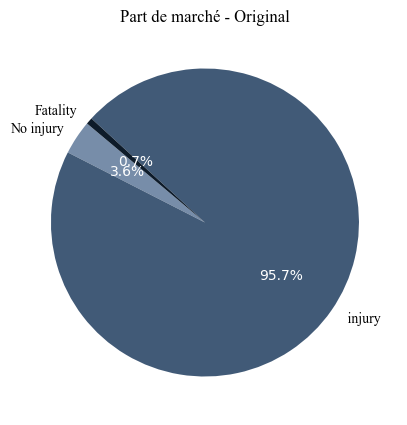

Scenario 1:
  Part de marché niveau 1: 3.5% (IC 90%: [2.6%, 4.6%])
  Part de marché niveau 2: 95.8% (IC 90%: [94.3%, 97.0%])
  Part de marché niveau 3: 0.7% (IC 90%: [0.3%, 1.3%])


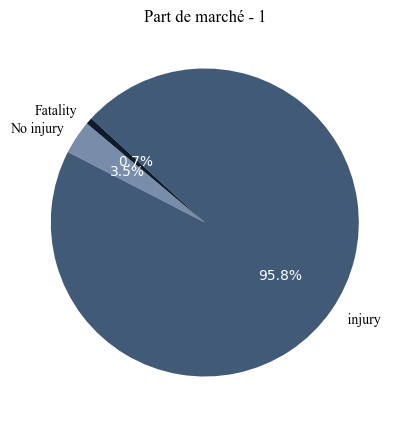

Scenario 2:
  Part de marché niveau 1: 3.7% (IC 90%: [2.7%, 4.9%])
  Part de marché niveau 2: 95.6% (IC 90%: [94.2%, 96.8%])
  Part de marché niveau 3: 0.7% (IC 90%: [0.3%, 1.3%])


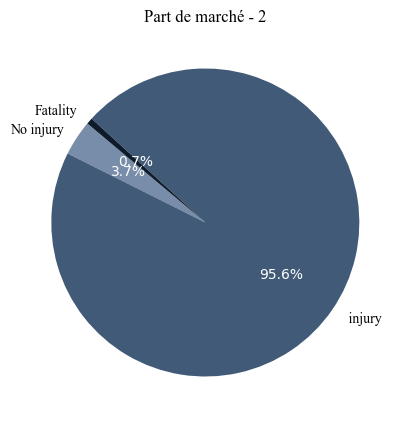

Scenario 3:
  Part de marché niveau 1: 3.8% (IC 90%: [2.8%, 5.0%])
  Part de marché niveau 2: 95.5% (IC 90%: [94.1%, 96.7%])
  Part de marché niveau 3: 0.7% (IC 90%: [0.3%, 1.2%])


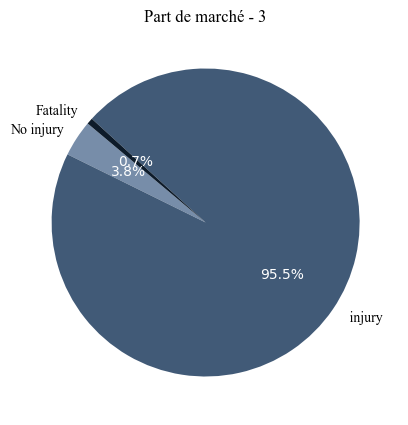

In [ ]:
import matplotlib.pyplot as plt

# Liste des bases de données pour les scénarios
databases = [database_carcrashes, database_scenario1, database_scenario2, database_scenario3]

# Noms pour chaque scénario
scenario_names = ['Original', '1','2','3','4']

for i, db in enumerate(databases):
    # Calcul des probabilités pour chaque niveau
    prob_level1 = models.logit(utility, availability, 1)
    prob_level2 = models.logit(utility, availability, 2)
    prob_level3 = models.logit(utility, availability, 3)

    # Préparer le modèle de simulation
    simulate = {
        'prob_level1': prob_level1,
        'prob_level2': prob_level2,
        'prob_level3': prob_level3,
    }

    biosim = bio.BIOGEME(db, simulate)
    simulated_values = biosim.simulate(results_logit_car.get_beta_values())

    # Calcul des parts de marché
    market_share_level1 = simulated_values['prob_level1'].mean()
    market_share_level2 = simulated_values['prob_level2'].mean()
    market_share_level3 = simulated_values['prob_level3'].mean()

    # Calcul des intervalles de confiance
    left, right = biosim.confidence_intervals(b, 0.9)

    left_market_share_level1 = left['prob_level1'].mean()
    right_market_share_level1 = right['prob_level1'].mean()
    
    left_market_share_level2 = left['prob_level2'].mean()
    right_market_share_level2 = right['prob_level2'].mean()
    
    left_market_share_level3 = left['prob_level3'].mean()
    right_market_share_level3 = right['prob_level3'].mean()
    


    # Imprimer les résultats
    print(f"Scenario {scenario_names[i]}:")
    print(f"  Part de marché niveau 1: {100 * market_share_level1:.1f}% (IC 90%: [{100 * left_market_share_level1:.1f}%, {100 * right_market_share_level1:.1f}%])")
    print(f"  Part de marché niveau 2: {100 * market_share_level2:.1f}% (IC 90%: [{100 * left_market_share_level2:.1f}%, {100 * right_market_share_level2:.1f}%])")
    print(f"  Part de marché niveau 3: {100 * market_share_level3:.1f}% (IC 90%: [{100 * left_market_share_level3:.1f}%, {100 * right_market_share_level3:.1f}%])")
    
    # Plot du camembert
    labels = ['No injury', ' injury',  'Fatality']
    colors = ['#778da9', '#415a77' ,'#0d1b2a']
    sizes = [market_share_level1, market_share_level2, market_share_level3]

    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        sizes, 
        labels=labels, 
        colors=colors, 
        autopct=lambda p: f'{p:.1f}%',  # Format des pourcentages
        startangle=140
    )

    # Mise à jour des couleurs des pourcentages
    for autotext in autotexts:
        autotext.set_color('white')

    # Mise à jour des couleurs des labels
    for text in texts:
        text.set_fontname('Times New Roman')
        text.set_color('black')

    plt.title(f"Part de marché - {scenario_names[i]}", fontname='Times New Roman')
    plt.show()


##  Scenarios  MMV

In [ ]:
import biogeme.database as db

# Scenario 1: Select rows where Vehicle is 'E-scooter' and Helmet is 'Yes'
# Créer une copie du DataFrame original
df_scenario_1 = df_mmv.copy()

# Mettre "Helmet_Yes" à 1 pour les lignes où "Vehicle_E-scooter" est égal à 1
df_scenario_1['Helmet_Yes'] = 1

# Scenario 2: Select rows where Helmet is 'Yes'
df_scenario_2 = df_mmv.copy()

df_scenario_2.loc[df_scenario_2['Accident location_On cycle facility'] == 0, 'Accident location_On cycle facility'] = 1

# Scenario 3: Select rows where age is greater than 16
df_scenario_3 = df_mmv.copy()

df_scenario_3.loc[df_scenario_3['age'] < 16, 'age'] = 16
df_scenario_3.loc[df_scenario_3['age_2'] < 16, 'age_2'] = 16


# Scenario 4: Set 'vma' column to 30 where 'vma' is greater than 30
df_scenario_4 = df_mmv.copy()  # Create a copy to avoid modifying the original DataFrame
df_scenario_4.loc['vma'] = 20

# Creating a database object with df_scenario_1
database_scenario1 = db.Database('scenario 1', df_scenario_1)
database_scenario2 = db.Database('scenario 2', df_scenario_2)
database_scenario3 = db.Database('scenario 3', df_scenario_3)
database_scenario4 = db.Database('scenario 4', df_scenario_4)

In [ ]:
results_bootstrapping = model_mmv.estimate(run_bootstrap=True, bootstrap_samples=100)
betas = results_logit_mmv.get_beta_values()  # Dictionnaire des paramètres estimés
beta = model_mmv.free_beta_names
b = results_bootstrapping.get_betas_for_sensitivity_analysis(beta)

NameError: name 'model_mmv' is not defined

Scenario Original:
  Part de marché niveau 1: 34.0% (IC 90%: [27.2%, 41.0%])
  Part de marché niveau 2: 66.0% (IC 90%: [59.0%, 72.8%])


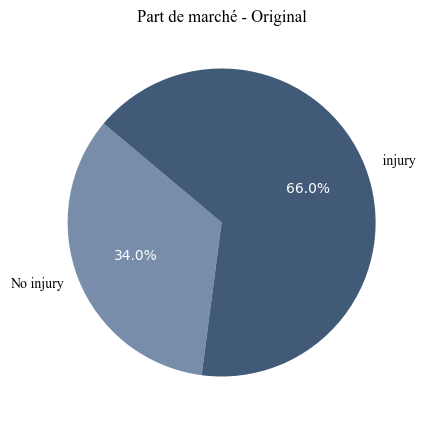

Scenario Scenario 1:
  Part de marché niveau 1: 34.3% (IC 90%: [27.5%, 41.3%])
  Part de marché niveau 2: 65.7% (IC 90%: [58.7%, 72.5%])


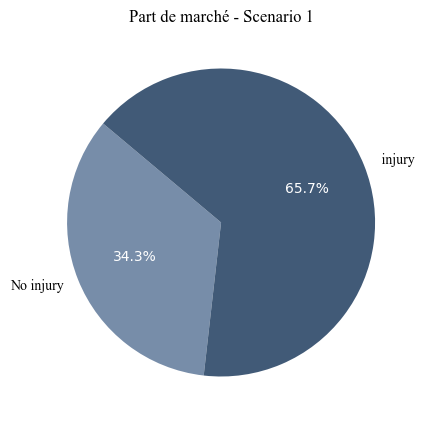

In [ ]:
import matplotlib.pyplot as plt

# Liste des bases de données pour les scénarios
databases = [database_mmv, database_scenario3]

# Noms pour chaque scénario
scenario_names = ['Original', 'Scenario 1','Scenario 2','Scenario 3','Scenario 4']

for i, db in enumerate(databases):
    # Calcul des probabilités pour chaque niveau
    prob_level1 = models.logit(V_mmv, availability1, 1)
    prob_level2 = models.logit(V_mmv, availability1, 2)

    # Préparer le modèle de simulation
    simulate = {
        'prob_level1': prob_level1,
        'prob_level2': prob_level2,
    }

    biosim = bio.BIOGEME(db, simulate)
    simulated_values = biosim.simulate(results_logit_mmv.get_beta_values())

    # Calcul des parts de marché
    market_share_level1 = simulated_values['prob_level1'].mean()
    market_share_level2 = simulated_values['prob_level2'].mean()

    # Calcul des intervalles de confiance
    left, right = biosim.confidence_intervals(b, 0.9)

    left_market_share_level1 = left['prob_level1'].mean()
    right_market_share_level1 = right['prob_level1'].mean()
    
    left_market_share_level2 = left['prob_level2'].mean()
    right_market_share_level2 = right['prob_level2'].mean()
    
   


    # Imprimer les résultats
    print(f"Scenario {scenario_names[i]}:")
    print(f"  Part de marché niveau 1: {100 * market_share_level1:.1f}% (IC 90%: [{100 * left_market_share_level1:.1f}%, {100 * right_market_share_level1:.1f}%])")
    print(f"  Part de marché niveau 2: {100 * market_share_level2:.1f}% (IC 90%: [{100 * left_market_share_level2:.1f}%, {100 * right_market_share_level2:.1f}%])")
    
    # Plot du camembert
    labels = ['No injury', ' injury']
    colors = ['#778da9', '#415a77' ]
    sizes = [market_share_level1, market_share_level2]

    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        sizes, 
        labels=labels, 
        colors=colors, 
        autopct=lambda p: f'{p:.1f}%',  # Format des pourcentages
        startangle=140
    )

    # Mise à jour des couleurs des pourcentages
    for autotext in autotexts:
        autotext.set_color('white')

    # Mise à jour des couleurs des labels
    for text in texts:
        text.set_fontname('Times New Roman')
        text.set_color('black')

    plt.title(f"Part de marché - {scenario_names[i]}", fontname='Times New Roman')
    plt.show()


## Scenario pedestrian

In [ ]:
import biogeme.database as db

# Scenario 1: Select rows where Vehicle is 'E-scooter' and Helmet is 'Yes'
# Créer une copie du DataFrame original
df_scenario_1 = df_alone.copy()

# Mettre "Helmet_Yes" à 1 pour les lignes où "Vehicle_E-scooter" est égal à 1
df_scenario_1.loc[df_scenario_1['Vehicle_E-scooter'] == 1, 'Helmet_Yes'] = 1

# Scenario 2: Select rows where Helmet is 'Yes'
df_scenario_2 = df_alone.copy()

df_scenario_2.loc[df_scenario_2['Accident location_On cycle facility'] == 0, 'Accident location_On cycle facility'] = 1

# Scenario 3: Select rows where age is greater than 16
df_scenario_3 = df_alone.copy()

df_scenario_3.loc[df_scenario_3['age'] < 16, 'age'] = 16

# Scenario 4: Set 'vma' column to 30 where 'vma' is greater than 30
df_scenario_4 = df_alone.copy()  # Create a copy to avoid modifying the original DataFrame
df_scenario_4.loc[df_scenario_4['vma'] > 20, 'vma'] = 20

# Creating a database object with df_scenario_1
database_scenario1 = db.Database('scenario 1', df_scenario_1)
database_scenario2 = db.Database('scenario 2', df_scenario_2)
database_scenario3 = db.Database('scenario 3', df_scenario_3)
database_scenario4 = db.Database('scenario 4', df_scenario_4)


In [ ]:
results_bootstrapping = model_pedes.estimate(run_bootstrap=True, bootstrap_samples=100)
betas = results_pedes.get_beta_values()  # Dictionnaire des paramètres estimés
beta = model_pedes.free_beta_names
b = results_bootstrapping.get_betas_for_sensitivity_analysis(beta)


In [ ]:
betas['tau_2']=betas['tau_1']+ betas['tau_1_diff_2']

# Liste des bases de données pour les scénarios
databases = [database_pedestrian, database_scenario2]

# Noms pour chaque scénario
scenario_names = ['Original', 'Scenario 2']

for i, db in enumerate(databases):
    # Calcul des probabilités pour chaque niveau

    prob_level1 = dist.logisticcdf(-utility_pedestrian + betas['tau_1'])
    prob_level2=-dist.logisticcdf(-utility_pedestrian+betas['tau_1'])+ dist.logisticcdf(-utility_pedestrian+betas['tau_2'])
    prob_level3= 1-dist.logisticcdf(-utility_pedestrian+betas['tau_2'])

    # Préparer le modèle de simulation
    simulate = {
        'prob_level1': prob_level1,
        'prob_level2': prob_level2,
        'prob_level3': prob_level3,
    }

    biosim = bio.BIOGEME(db, simulate)
    simulated_values = biosim.simulate(results_pedes.get_beta_values())

    # Calcul des parts de marché
    market_share_level1 = simulated_values['prob_level1'].mean()
    market_share_level2 = simulated_values['prob_level2'].mean()
    market_share_level3 = simulated_values['prob_level3'].mean()

    # Calcul des intervalles de confiance
    left, right = biosim.confidence_intervals(b, 0.9)

    left_market_share_level1 = left['prob_level1'].mean()
    right_market_share_level1 = right['prob_level1'].mean()
    
    left_market_share_level2 = left['prob_level2'].mean()
    right_market_share_level2 = right['prob_level2'].mean()
    
    left_market_share_level3 = left['prob_level3'].mean()
    right_market_share_level3 = right['prob_level3'].mean()
    


    # Imprimer les résultats
    print(f"Scenario {scenario_names[i]}:")
    print(f"  Part de marché niveau 1: {100 * market_share_level1:.1f}% (IC 90%: [{100 * left_market_share_level1:.1f}%, {100 * right_market_share_level1:.1f}%])")
    print(f"  Part de marché niveau 2: {100 * market_share_level2:.1f}% (IC 90%: [{100 * left_market_share_level2:.1f}%, {100 * right_market_share_level2:.1f}%])")
    print(f"  Part de marché niveau 3: {100 * market_share_level3:.1f}% (IC 90%: [{100 * left_market_share_level3:.1f}%, {100 * right_market_share_level3:.1f}%])")
    
    # Plot du camembert
    labels = ['No injury', ' injury',  'Fatality']
    colors = ['#778da9', '#415a77' ,'#0d1b2a']
    sizes = [market_share_level1, market_share_level2, market_share_level3]

    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        sizes, 
        labels=labels, 
        colors=colors, 
        autopct=lambda p: f'{p:.1f}%',  # Format des pourcentages
        startangle=140
    )

    # Mise à jour des couleurs des pourcentages
    for autotext in autotexts:
        autotext.set_color('white')

    # Mise à jour des couleurs des labels
    for text in texts:
        text.set_fontname('Times New Roman')
        text.set_color('black')

    plt.title(f"Part de marché - {scenario_names[i]}", fontname='Times New Roman')
    plt.show()


In [ ]:
import biogeme.database as db

# Scenario 1: Select rows where Vehicle is 'E-scooter' and Helmet is 'Yes'
# Créer une copie du DataFrame original
df_scenario_1 = df_alone.copy()

# Mettre "Helmet_Yes" à 1 pour les lignes où "Vehicle_E-scooter" est égal à 1
df_scenario_1['Helmet_Yes'] = 1

# Scenario 2: Select rows where Helmet is 'Yes'
df_scenario_2 = df_alone.copy()

df_scenario_2.loc[df_scenario_2['Accident location_On cycle facility'] == 0, 'Accident location_On cycle facility'] = 1

# Scenario 3: Select rows where age is greater than 16
df_scenario_3 = df_alone.copy()

df_scenario_3.loc[df_scenario_3['age'] < 16, 'age'] = 16

# Scenario 4: Set 'vma' column to 30 where 'vma' is greater than 30
df_scenario_4 = df_alone.copy()  # Create a copy to avoid modifying the original DataFrame
df_scenario_4.loc[df_scenario_4['vma'] > 20, 'vma'] = 20

# Creating a database object with df_scenario_1
database_scenario1 = db.Database('scenario 1', df_scenario_1)
database_scenario2 = db.Database('scenario 2', df_scenario_2)
database_scenario3 = db.Database('scenario 3', df_scenario_3)
database_scenario4 = db.Database('scenario 4', df_scenario_4)


In [ ]:
results_bootstrapping = model_solo.estimate(run_bootstrap=True, bootstrap_samples=100)

100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


In [ ]:
betas = results_solo.get_beta_values()  # Dictionnaire des paramètres estimés
beta = model_solo.free_beta_names
b = results_bootstrapping.get_betas_for_sensitivity_analysis(beta)


Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.

Scenario Original:
  Part de marché niveau 1: 1.8% (IC 90%: [0.7%, 5.6%])
  Part de marché niveau 2: 97.2% (IC 90%: [92.5%, 98.0%])
  Part de marché niveau 3: 1.0% (IC 90%: [0.2%, 3.8%])


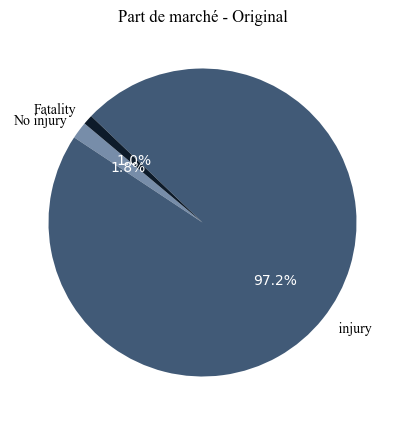

Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.
Parameter tau_1 not present in the model.
Parameter tau_1_diff_2 not present in the model.

Scenario Scenario 1:
  Part de marché niveau 1: 2.4% (IC 90%: [1.0%, 6.2%])
  Part de marché niveau 2: 96.9% (IC 90%: [92.7%, 97.8%])
  Part de marché niveau 3: 0.7% (IC 90%: [0.2%, 2.7%])


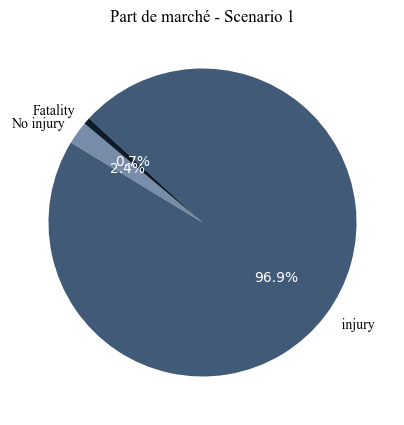

In [ ]:
betas['tau_2']=betas['tau_1']+ betas['tau_1_diff_2']

# Liste des bases de données pour les scénarios
databases = [database_carcrashes, database_scenario4]

# Noms pour chaque scénario
scenario_names = ['Original', 'Scenario 1']

for i, db in enumerate(databases):
    # Calcul des probabilités pour chaque niveau

    prob_level1 = dist.logisticcdf(-utility_sv + betas['tau_1'])
    prob_level2=-dist.logisticcdf(-utility_sv+betas['tau_1'])+ dist.logisticcdf(-utility_sv+betas['tau_2'])
    prob_level3= 1-dist.logisticcdf(-utility_sv+betas['tau_2'])

    # Préparer le modèle de simulation
    simulate = {
        'prob_level1': prob_level1,
        'prob_level2': prob_level2,
        'prob_level3': prob_level3,
    }

    biosim = bio.BIOGEME(db, simulate)
    simulated_values = biosim.simulate(results_solo.get_beta_values())

    # Calcul des parts de marché
    market_share_level1 = simulated_values['prob_level1'].mean()
    market_share_level2 = simulated_values['prob_level2'].mean()
    market_share_level3 = simulated_values['prob_level3'].mean()

    # Calcul des intervalles de confiance
    left, right = biosim.confidence_intervals(b, 0.9)

    left_market_share_level1 = left['prob_level1'].mean()
    right_market_share_level1 = right['prob_level1'].mean()
    
    left_market_share_level2 = left['prob_level2'].mean()
    right_market_share_level2 = right['prob_level2'].mean()
    
    left_market_share_level3 = left['prob_level3'].mean()
    right_market_share_level3 = right['prob_level3'].mean()
    


    # Imprimer les résultats
    print(f"Scenario {scenario_names[i]}:")
    print(f"  Part de marché niveau 1: {100 * market_share_level1:.1f}% (IC 90%: [{100 * left_market_share_level1:.1f}%, {100 * right_market_share_level1:.1f}%])")
    print(f"  Part de marché niveau 2: {100 * market_share_level2:.1f}% (IC 90%: [{100 * left_market_share_level2:.1f}%, {100 * right_market_share_level2:.1f}%])")
    print(f"  Part de marché niveau 3: {100 * market_share_level3:.1f}% (IC 90%: [{100 * left_market_share_level3:.1f}%, {100 * right_market_share_level3:.1f}%])")
    
    # Plot du camembert
    labels = ['No injury', ' injury',  'Fatality']
    colors = ['#778da9', '#415a77' ,'#0d1b2a']
    sizes = [market_share_level1, market_share_level2, market_share_level3]

    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        sizes, 
        labels=labels, 
        colors=colors, 
        autopct=lambda p: f'{p:.1f}%',  # Format des pourcentages
        startangle=140
    )

    # Mise à jour des couleurs des pourcentages
    for autotext in autotexts:
        autotext.set_color('white')

    # Mise à jour des couleurs des labels
    for text in texts:
        text.set_fontname('Times New Roman')
        text.set_color('black')

    plt.title(f"Part de marché - {scenario_names[i]}", fontname='Times New Roman')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Liste des bases de données pour les scénarios
databases = [database_carcrashes, database_scenario1, database_scenario2, database_scenario3, database_scenario4]

# Noms pour chaque scénario
scenario_names = ['Original', 'Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']

# Initialisation des listes pour stocker les parts de marché et les intervalles de confiance
market_shares_level1 = []
market_shares_level2 = []
market_shares_level3 = []

ci_left_level1 = []
ci_right_level1 = []

ci_left_level2 = []
ci_right_level2 = []

ci_left_level3 = []
ci_right_level3 = []


NameError: name 'database_carcrashes' is not defined

In [ ]:

for i, db in enumerate(databases):
    # Calcul des probabilités pour chaque niveau
    prob_level1 = models.logit(utility, availability, 1)
    prob_level2 = models.logit(utility, availability, 2)
    prob_level3 = models.logit(utility, availability, 3)

    # Préparer le modèle de simulation
    simulate = {
        'prob_level1': prob_level1,
        'prob_level2': prob_level2,
        'prob_level3': prob_level3,
    }

    biosim = bio.BIOGEME(db, simulate)
    simulated_values = biosim.simulate(results_logit_car.get_beta_values())

    # Calcul des parts de marché
    market_share_level1 = simulated_values['prob_level1'].mean()
    market_share_level2 = simulated_values['prob_level2'].mean()
    market_share_level3 = simulated_values['prob_level3'].mean()

    # Calcul des intervalles de confiance
    left, right = biosim.confidence_intervals(b, 0.9)

    left_market_share_level1 = left['prob_level1'].mean()
    right_market_share_level1 = right['prob_level1'].mean()
    
    left_market_share_level2 = left['prob_level2'].mean()
    right_market_share_level2 = right['prob_level2'].mean()
    
    left_market_share_level3 = left['prob_level3'].mean()
    right_market_share_level3 = right['prob_level3'].mean()

    # Stocker les résultats
    market_shares_level1.append(market_share_level1)
    market_shares_level2.append(market_share_level2)
    market_shares_level3.append(market_share_level3)

    ci_left_level1.append(left_market_share_level1)
    ci_right_level1.append(right_market_share_level1)

    ci_left_level2.append(left_market_share_level2)
    ci_right_level2.append(right_market_share_level2)

    ci_left_level3.append(left_market_share_level3)
    ci_right_level3.append(right_market_share_level3)

# Tracer les graphiques
x = np.arange(len(scenario_names))

plt.figure(figsize=(10, 6))

# Niveau 1
plt.errorbar(x, market_shares_level1, yerr=[np.array(market_shares_level1) - np.array(ci_left_level1), np.array(ci_right_level1) - np.array(market_shares_level1)], fmt='-o', label='No injury', color='#778da9')

# Niveau 2
plt.errorbar(x, market_shares_level2, yerr=[np.array(market_shares_level2) - np.array(ci_left_level2), np.array(ci_right_level2) - np.array(market_shares_level2)], fmt='-o', label='Injury', color='#415a77')

# Niveau 3
plt.errorbar(x, market_shares_level3, yerr=[np.array(market_shares_level3) - np.array(ci_left_level3), np.array(ci_right_level3) - np.array(market_shares_level3)], fmt='-o', label='Fatality', color='#0d1b2a')

plt.xticks(x, scenario_names, rotation=45, ha='right')
plt.xlabel('Scenarios')
plt.ylabel('Market Share')
plt.title('Evolution of Market Share by Scenario')
plt.legend()
plt.tight_layout()
plt.show()

## Out-of sample validation

In [ ]:
import pandas as pd

# Assuming df_carcrashes, df_mmv, df_alone, df_pedestrian are already defined

# Create DataFrames for each year and without each year
years = [2019, 2020, 2021, 2022, 2023]

# Classe pour contenir les données de validation
class ValidationData:
    def __init__(self, estimation, validation):
        self.estimation = estimation
        self.validation = validation

# Fonction pour créer des tuples de DataFrames pour chaque année et sans chaque année
def create_validation_data(df):
    validation_data=[]
    validation_data.append(ValidationData(df[df['Year'].isin([2019, 2020, 2021, 2022])], df[df['Year'] == 2023]))
    df_lyon = df[df['Agglomeration_MÉTROPOLE DE LYON'] == 1]
    df_paris = df[df['Agglomeration_MÉTROPOLE DU GRAND PARIS']==1]
    validation_data.append(ValidationData(df_paris, df_lyon))
    return validation_data



# Create validation data for each dataset
validationData_car = create_validation_data(df_carcrashes)
validationData_mmv= create_validation_data(df_mmv)
validationData_alone_2 = create_validation_data(df_alone)
validationData_pedestrian = create_validation_data(df_pedestrian)

In [ ]:
# Validate the model with the validation data for mmv
validation_results_mmv = model_car.validate(results_logit_car, validationData_car)
validation_results_mmv_cst = model_cst_car.validate(results_logit_car, validationData_car)


# Initialize variables to store log-likelihoods
loglike_model_mmv = 0
loglike_constant_mmv = 0
loglike_model_car = 0
loglike_constant_car = 0

# Calculate log-likelihood for the model (mmv)
for i, slide in enumerate(validation_results_mmv):
    validation_loglike = slide['Loglikelihood'].sum()
    loglike_model_mmv += validation_loglike
    print(
        f'Log likelihood for {slide.shape[0]} validation data on car (slide {i+1}): '
        f'{validation_loglike}'
    )

# Calculate log-likelihood for the constant model (mmv)
for i, slide in enumerate(validation_results_mmv_cst):
    validation_loglike_cst = slide['Loglikelihood'].sum()
    loglike_constant_mmv += validation_loglike_cst
    print(
        f'Log likelihood for {slide.shape[0]} validation data on car (constant model, slide {i+1}): '
        f'{validation_loglike_cst}'
    )

# Calculate rho-square for each slide (mmv)
for i in range(len(validation_results_mmv)):
    validation_loglike = validation_results_mmv[i]['Loglikelihood'].sum()
    validation_loglike_cst = validation_results_mmv_cst[i]['Loglikelihood'].sum()
    rho_square = 1 - (validation_loglike / validation_loglike_cst)
    print(f'Rho-square for the validation data on mmv (slide {i+1}): {rho_square}')





The number of draws (10) is low. The results may not be meaningful.
The number of draws (10) is low. The results may not be meaningful.


Log likelihood for 2129 validation data on car (slide 1): -385.0983142418628
Log likelihood for 1361 validation data on car (slide 2): -226.28407309572674
Log likelihood for 2129 validation data on car (constant model, slide 1): -400.5345691339352
Log likelihood for 1361 validation data on car (constant model, slide 2): -249.84562294641995
Rho-square for the validation data on mmv (slide 1): 0.03853913265326825
Rho-square for the validation data on mmv (slide 2): 0.094304433164899


In [ ]:
# Validate the model with the validation data for mmv
validation_results_mmv = model_mmv.validate(results_logit_mmv, validationData_mmv)
validation_results_mmv_cst = model_cst_mmv.validate(results_constant_mmv, validationData_mmv)


# Initialize variables to store log-likelihoods
loglike_model_mmv = 0
loglike_constant_mmv = 0
loglike_model_car = 0
loglike_constant_car = 0

# Calculate log-likelihood for the model (mmv)
for i, slide in enumerate(validation_results_mmv):
    validation_loglike = slide['Loglikelihood'].sum()
    loglike_model_mmv += validation_loglike
    print(
        f'Log likelihood for {slide.shape[0]} validation data on mmv (slide {i+1}): '
        f'{validation_loglike}'
    )

# Calculate log-likelihood for the constant model (mmv)
for i, slide in enumerate(validation_results_mmv_cst):
    validation_loglike_cst = slide['Loglikelihood'].sum()
    loglike_constant_mmv += validation_loglike_cst
    print(
        f'Log likelihood for {slide.shape[0]} validation data on mmv (constant model, slide {i+1}): '
        f'{validation_loglike_cst}'
    )

# Calculate rho-square for each slide (mmv)
for i in range(len(validation_results_mmv)):
    validation_loglike = validation_results_mmv[i]['Loglikelihood'].sum()
    validation_loglike_cst = validation_results_mmv_cst[i]['Loglikelihood'].sum()
    rho_square = 1 - (validation_loglike / validation_loglike_cst)
    print(f'Rho-square for the validation data on mmv (slide {i+1}): {rho_square}')





Log likelihood for 374 validation data on mmv (slide 1): -192.50640797933738
Log likelihood for 87 validation data on mmv (slide 2): -41.87989331325306
Log likelihood for 374 validation data on mmv (constant model, slide 1): -237.1036285337441
Log likelihood for 87 validation data on mmv (constant model, slide 2): -53.45155740384912
Rho-square for the validation data on mmv (slide 1): 0.1880916830762871
Rho-square for the validation data on mmv (slide 2): 0.21648881066583792


In [ ]:

# Validate the model with the validation data for mmv
validation_results_mmv = model_pedes.validate(results_logit_mmv, validationData_pedestrian)
validation_results_mmv_cst = model_cst_pedes.validate(results_pedes_cst, validationData_pedestrian)


# Initialize variables to store log-likelihoods
loglike_model_mmv = 0
loglike_constant_mmv = 0
loglike_model_car = 0
loglike_constant_car = 0

# Calculate log-likelihood for the model (mmv)
for i, slide in enumerate(validation_results_mmv):
    validation_loglike = slide['Loglikelihood'].sum()
    loglike_model_mmv += validation_loglike
    print(
        f'Log likelihood for {slide.shape[0]} validation data on mmv (slide {i+1}): '
        f'{validation_loglike}'
    )

# Calculate log-likelihood for the constant model (mmv)
for i, slide in enumerate(validation_results_mmv_cst):
    validation_loglike_cst = slide['Loglikelihood'].sum()
    loglike_constant_mmv += validation_loglike_cst
    print(
        f'Log likelihood for {slide.shape[0]} validation data on mmv (constant model, slide {i+1}): '
        f'{validation_loglike_cst}'
    )

# Calculate rho-square for each slide (mmv)
for i in range(len(validation_results_mmv)):
    validation_loglike = validation_results_mmv[i]['Loglikelihood'].sum()
    validation_loglike_cst = validation_results_mmv_cst[i]['Loglikelihood'].sum()
    rho_square = 1 - (validation_loglike / validation_loglike_cst)
    print(f'Rho-square for the validation data on mmv (slide {i+1}): {rho_square}')




Log likelihood for 711 validation data on mmv (slide 1): -305.8346190959127
Log likelihood for 223 validation data on mmv (slide 2): -91.33008012022226
Log likelihood for 711 validation data on mmv (constant model, slide 1): -491.29119757943675
Log likelihood for 223 validation data on mmv (constant model, slide 2): -151.99746503812216
Rho-square for the validation data on mmv (slide 1): 0.3774880954457517
Rho-square for the validation data on mmv (slide 2): 0.3991341888674528


In [ ]:


# Validate the model with the validation data for mmv
validation_results_solo_2 = model_solo_2.validate(results_solo_2, validationData_alone_2)
validation_results_solo_cst = model_cst_solo.validate(results_cst_solo, validationData_alone_2)

# Initialize variables to store log-likelihoods
loglike_model_mmv = 0
loglike_constant_mmv = 0
loglike_model_car = 0
loglike_constant_car = 0

# Calculate log-likelihood for the model (mmv)
for i, slide in enumerate(validation_results_solo_2):
    validation_loglike = slide['Loglikelihood'].sum()
    loglike_model_mmv += validation_loglike
    print(
        f'Log likelihood for {slide.shape[0]} validation data on mmv (slide {i+1}): '
        f'{validation_loglike}'
    )

# Calculate log-likelihood for the constant model (mmv)
for i, slide in enumerate(validation_results_solo_cst):
    validation_loglike_cst = slide['Loglikelihood'].sum()
    loglike_constant_mmv += validation_loglike_cst
    print(
        f'Log likelihood for {slide.shape[0]} validation data on mmv (constant model, slide {i+1}): '
        f'{validation_loglike_cst}'
    )

# Calculate rho-square for each slide (mmv)
for i in range(len(validation_results_solo_2)):
    validation_loglike = validation_results_solo_2[i]['Loglikelihood'].sum()
    validation_loglike_cst = validation_results_solo_cst[i]['Loglikelihood'].sum()
    rho_square = 1 - (validation_loglike / validation_loglike_cst)

    # Calculate rho-square for each slide (mmv)
for i in range(len(validation_results_solo_2)):
    validation_loglike = validation_results_solo_2[i]['Loglikelihood'].sum()
    validation_loglike_cst = validation_results_solo_cst[i]['Loglikelihood'].sum()
    rho_square = 1 - (validation_loglike / validation_loglike_cst)
    print(f'Rho-square for the validation data on mmv (slide {i+1}): {rho_square}')


Log likelihood for 422 validation data on mmv (slide 1): -70.88559195594817
Log likelihood for 222 validation data on mmv (slide 2): -63.45182821381694
Log likelihood for 422 validation data on mmv (constant model, slide 1): -83.79757467068754
Log likelihood for 222 validation data on mmv (constant model, slide 2): -76.58264262870634
Rho-square for the validation data on mmv (slide 1): 0.15408539883739603
Rho-square for the validation data on mmv (slide 2): 0.17145940599818665
